In [1]:
%load_ext autoreload
import ddls

Initialise what type(s) of nodes (servers) you want in your cluster and what type(s) of worker(s) you want to populate them with.

In [39]:
%autoreload
from ddls.devices.processors.gpus.A100 import A100

import json


node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100
                              }
                          ]
                  }
              }

print(node_config)

{'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


Initialise the topology to be populated by your nodes.

In [40]:
topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

Initialise the cluster environment using your node and topology configuration.

Cluster <class 'ddls.clusters.cluster.Cluster'> | Topology: <class 'ddls.topologies.torus.Torus'> with 16 nodes and 32 | Topology config: {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}} | Node config: {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


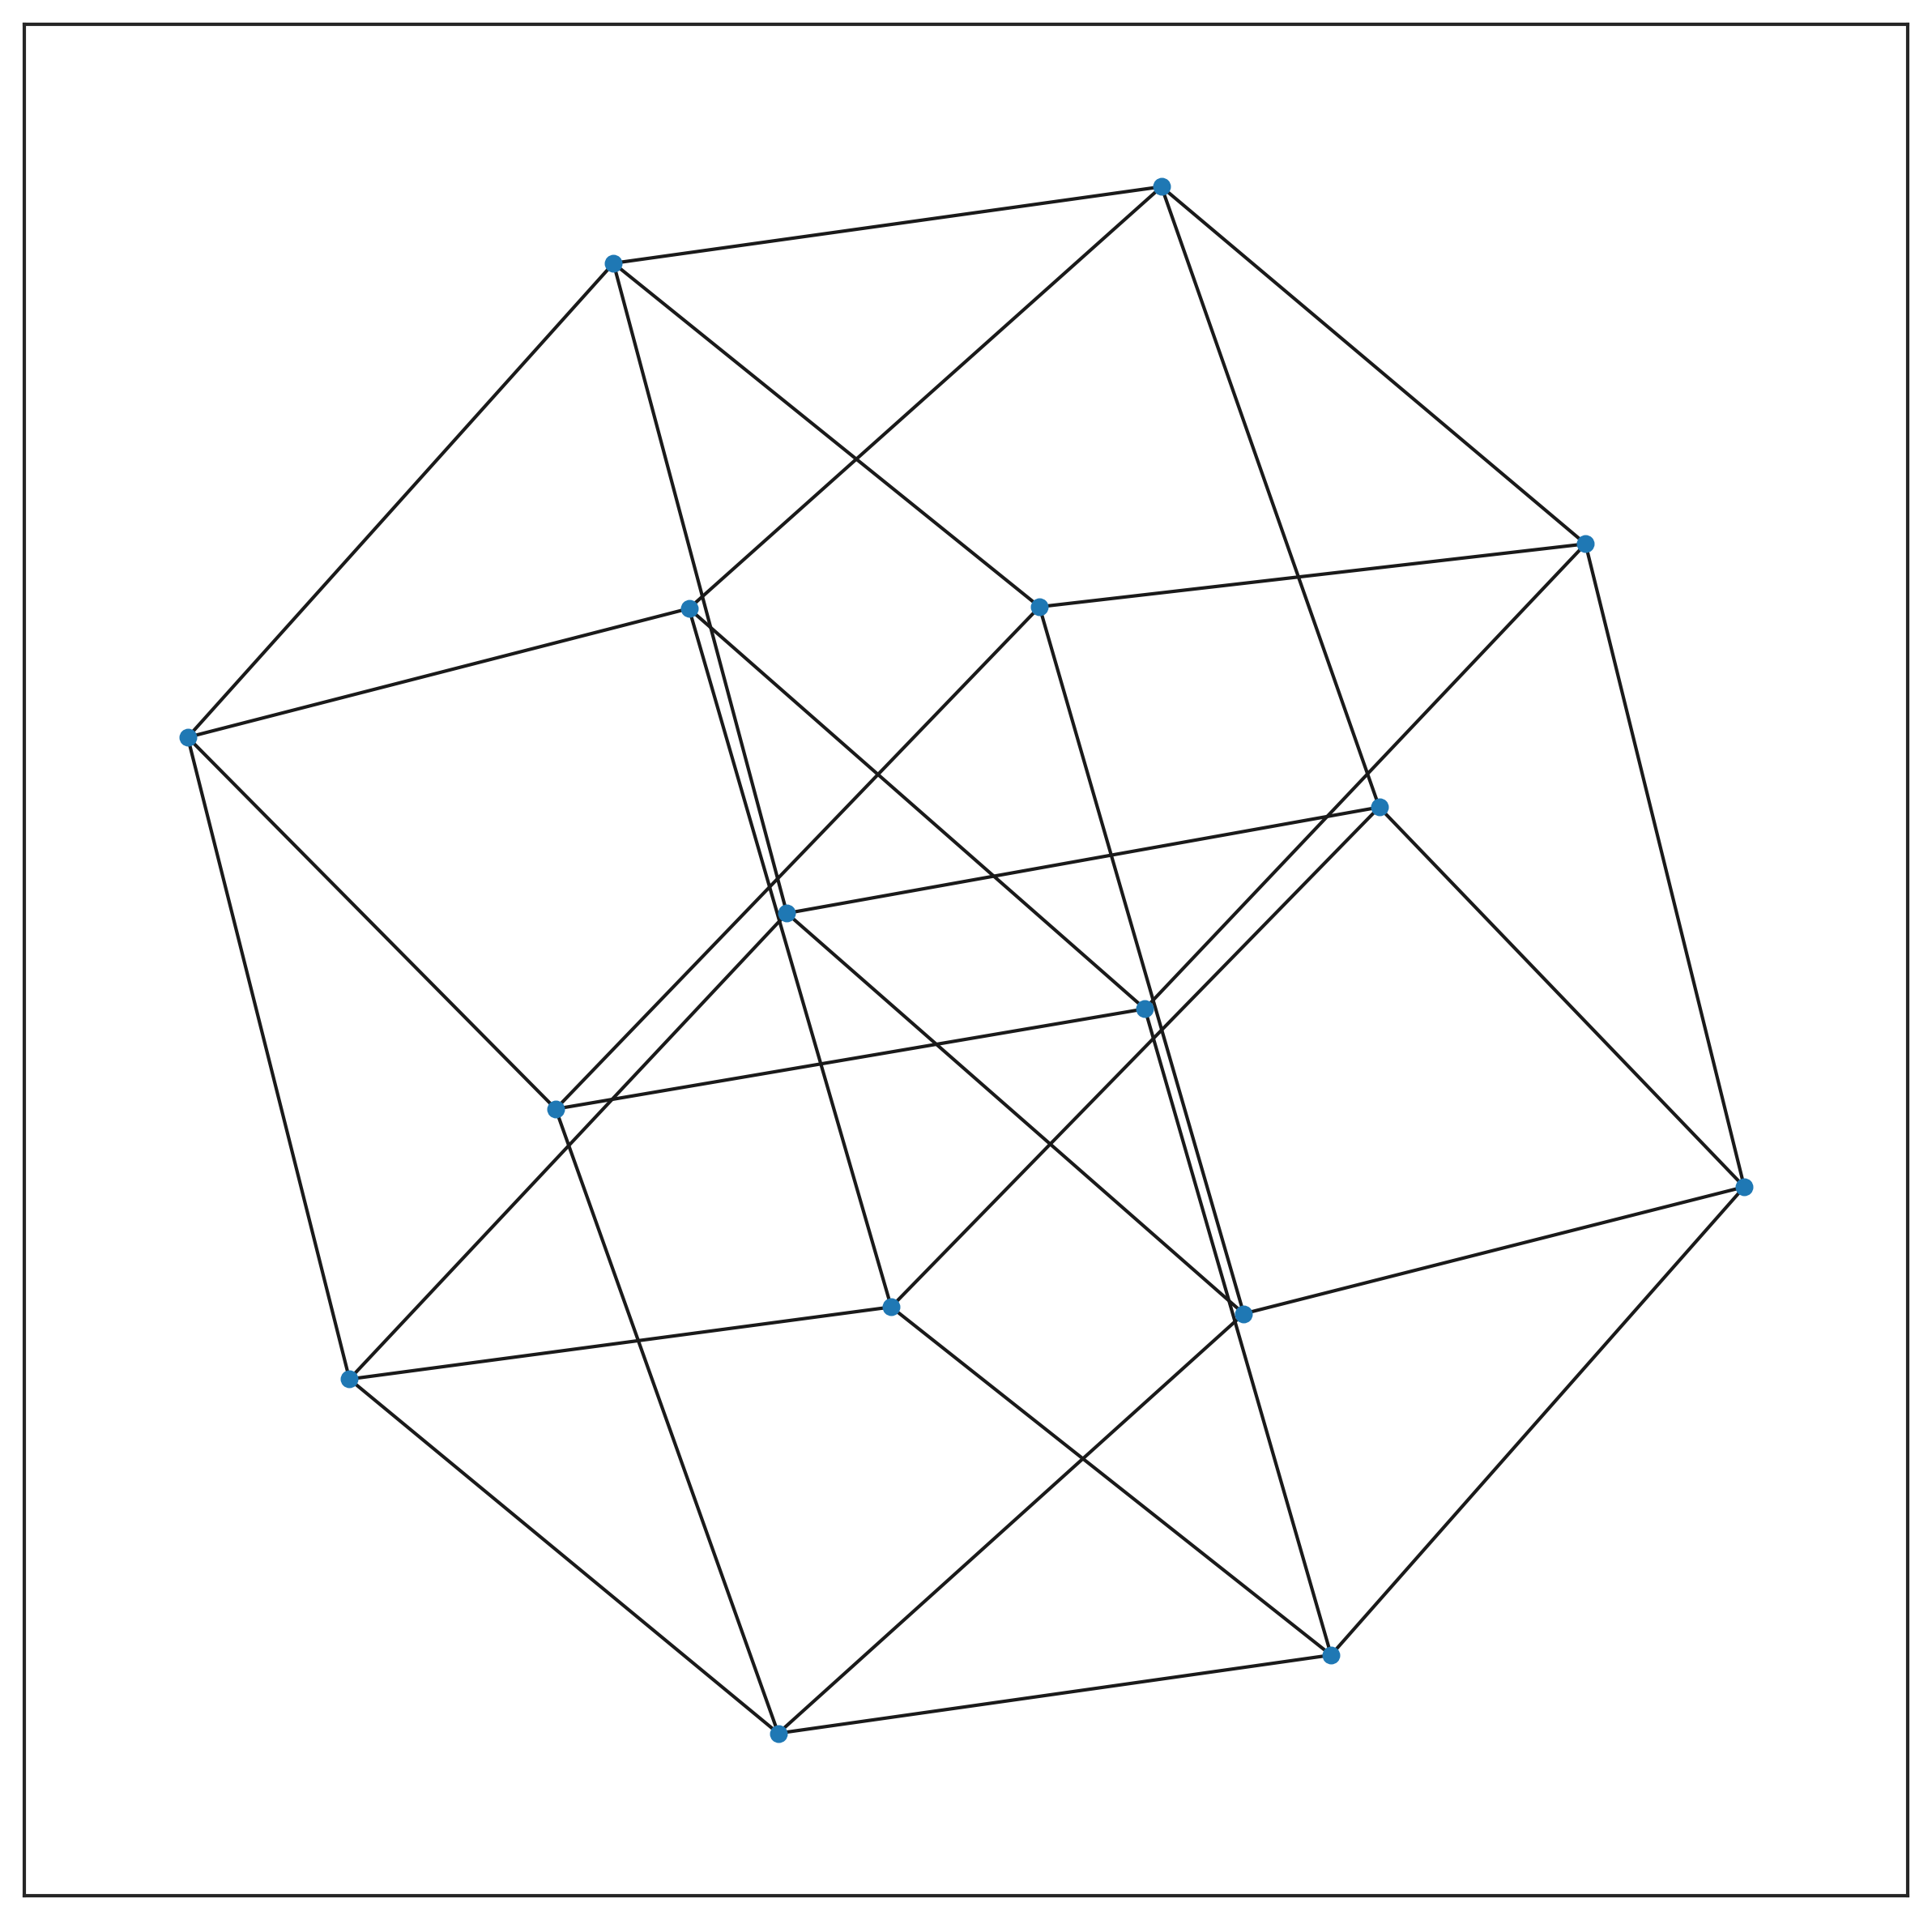

Node 1-1-1: {'workers': {139768919006752: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7cc49e20>, 139768922816128: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7cfebe80>, 139768969898736: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7fcd2af0>, 139768969898016: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7fcd2820>}}
Node 2-1-1: {'workers': {139768969899168: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7fcd2ca0>, 139768922816080: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7cfebe50>, 139768969898160: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7fcd28b0>, 139768969898304: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7fcd2940>}}
Node 3-1-1: {'workers': {139768969896864: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7fcd23a0>, 139768969897056: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7fcd2460>, 139768969898496: <ddls.devices.processors.gpus.A100.A100 object at 0x7f1e7fcd2a00>,

In [41]:
%autoreload
from ddls.clusters.cluster import Cluster

env = Cluster(topology_config=topology_config,
              node_config=node_config,
              path_to_save='/scratch/datasets/ddls/sims',
              save_freq=100,
              use_sqlite_database=True)
print(env)
env.topology.render()

for node in env.topology.graph:
    print(f'Node {node}: {env.topology.graph.nodes[node]}')

Load the `ddls` computation graph(s) you want to run on the cluster.

In [42]:
%autoreload
from ddls.utils import ddls_graph_from_pbtxt_file
from ddls.plotting.plotting import plot_computation_graph

import glob


# get file paths
path_to_files = '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid'
file_paths = glob.glob(path_to_files + '/*')
    
# create ddls graph
num_graphs = 100
ddls_computation_graphs = [ddls_graph_from_pbtxt_file(file_path, processor_type_profiled='A100', verbose=False) for file_path in file_paths[:num_graphs]]

# visualise
visualise = False
if visualise:
    for graph in ddls_computation_graphs:
        fig = plot_computation_graph(graph, scaling_factor=3, title='ddls_graph', show_fig=True, verbose=True)

Initialise `ddls` job(s) from the computation graph(s)

In [43]:
%autoreload
from ddls.demands.jobs.job import Job

jobs = [Job(computation_graph=graph, num_training_steps=2) for graph in ddls_computation_graphs]

for job in jobs:
    print(job)

Job ID: 139768973111200 | # nodes: 96 | # edges: 410 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 13901
Job ID: 139768969897200 | # nodes: 68 | # edges: 128 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 3996
Job ID: 139768969898976 | # nodes: 85 | # edges: 302 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 11412
Job ID: 139768969897296 | # nodes: 156 | # edges: 672 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 22580
Job ID: 139768969899696 | # nodes: 115 | # edges: 328 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 11189
Job ID: 139768969896720 | # nodes: 63 | # edges: 164 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 6206
Job ID: 139768969897536 | # nodes: 149 | # edges: 600 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 20935
Job ID: 139769176282976 | # nodes: 54 | # edges: 124 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 3757
Job ID: 139769176282160 

Initialise an operation placement agent.

In [44]:
%autoreload
from ddls.managers.placers.random_job_placer import RandomJobPlacer
from ddls.managers.schedulers.srpt_job_scheduler import SRPTJobScheduler

control_plane = {
    'job_placer': RandomJobPlacer(),
    'job_scheduler': SRPTJobScheduler()
}

Reset cluster environment

In [45]:
%autoreload
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally

seed = 0
seed_stochastic_modules_globally(seed)
obs, action_set, reward, done, info = env.reset(jobs=jobs,
                                                job_sampling_mode='remove',
                                                job_interarrival_time_dist=Uniform(min_val=1, max_val=1000),
                                                max_simulation_run_time=float('inf'),
                                                job_queue_capacity=10,
                                                seed=seed,
                                                verbose=True)

Reset cluster environment.
Job interarrival time dist: Distribution type: <class 'ddls.distributions.uniform.Uniform'> | min_val: 1 | max_val: 1000 | interval: 1 | decimals: 10
Job sampler: Original pool: [<ddls.demands.jobs.job.Job object at 0x7f1e7ffe2fa0>, <ddls.demands.jobs.job.Job object at 0x7f1e7fcd24f0>, <ddls.demands.jobs.job.Job object at 0x7f1e7fcd2be0>, <ddls.demands.jobs.job.Job object at 0x7f1e7fcd2550>, <ddls.demands.jobs.job.Job object at 0x7f1e7fcd2eb0>, <ddls.demands.jobs.job.Job object at 0x7f1e7fcd2310>, <ddls.demands.jobs.job.Job object at 0x7f1e7fcd2640>, <ddls.demands.jobs.job.Job object at 0x7f1e8c1a5760>, <ddls.demands.jobs.job.Job object at 0x7f1e8c1a5430>, <ddls.demands.jobs.job.Job object at 0x7f1e8c1a5250>, <ddls.demands.jobs.job.Job object at 0x7f1e8c1a58b0>, <ddls.demands.jobs.job.Job object at 0x7f1e8c1a5ca0>, <ddls.demands.jobs.job.Job object at 0x7f1e8c1a5040>, <ddls.demands.jobs.job.Job object at 0x7f1e8c1a5c10>, <ddls.demands.jobs.job.Job object at 0

**TODO**: Implement logic for placing job ops of each job -> step env -> time job completion for 1 training step (can then think about $n$ training steps, network communication overhead, etc.)

- Have mounted job onto devices
- Now need to work out way of tracking ops running on each device efficiently and timing how long they take. Consider having global dict tracking operations which are running to avoid having to keep looping through all ops to check dependencies. Consider also having stopwatch object similar to Noah's where only tick it when have stacked enough sequential operations. N.B. Think should assume that, once ops have been placed on a device, they must be ran sequentially (i.e. cannot run multiple ops on one device at the same time; assume time profile is for e.g. GPU worker running just that one op with <= all its cores)

In [46]:
%autoreload
import pprint
import time

start_time = time.time()
while not done:
    # make decisions
    actions = {}
    actions['job_placement'] = control_plane['job_placer'].get_placement(cluster=env)
    actions['job_schedule'] = control_plane['job_scheduler'].get_schedule(new_placements=actions['job_placement'], cluster=env)
    
#     print('')
#     print('-'*80)
#     pprint.pprint(actions)
#     print('-'*80)
#     print('')
    
    # pass actions to cluster environment and move to next step
    obs, action_set, reward, done, info = env.step(actions, verbose=False)
    
    print(f'Step {env.step_counter} | Jobs arrived: {env.num_jobs_arrived} | completed: {len(env.jobs_completed)} | blocked: {len(env.jobs_blocked)} | running: {len(env.jobs_running)} | queued: {len(env.job_queue)}')
    
#     raise Exception()

print(f'\nCompleted simulation in {time.time() - start_time:.3f} s')

Step 1 | Jobs arrived: 2 | completed: 0 | blocked: 0 | running: 1 | queued: 1
Step 2 | Jobs arrived: 3 | completed: 0 | blocked: 0 | running: 2 | queued: 1
Step 3 | Jobs arrived: 4 | completed: 0 | blocked: 0 | running: 3 | queued: 1
Step 4 | Jobs arrived: 5 | completed: 0 | blocked: 0 | running: 4 | queued: 1
Step 5 | Jobs arrived: 6 | completed: 0 | blocked: 0 | running: 5 | queued: 1
Step 6 | Jobs arrived: 7 | completed: 0 | blocked: 0 | running: 6 | queued: 1
Step 7 | Jobs arrived: 8 | completed: 0 | blocked: 0 | running: 7 | queued: 1
Step 8 | Jobs arrived: 9 | completed: 0 | blocked: 0 | running: 8 | queued: 1
Step 9 | Jobs arrived: 10 | completed: 0 | blocked: 0 | running: 9 | queued: 1
Step 10 | Jobs arrived: 11 | completed: 0 | blocked: 0 | running: 10 | queued: 1
Step 11 | Jobs arrived: 12 | completed: 0 | blocked: 0 | running: 11 | queued: 1
Step 12 | Jobs arrived: 13 | completed: 0 | blocked: 0 | running: 12 | queued: 1
Step 13 | Jobs arrived: 14 | completed: 0 | blocked: 0

Step 103 | Jobs arrived: 84 | completed: 20 | blocked: 0 | running: 63 | queued: 1
Step 104 | Jobs arrived: 84 | completed: 21 | blocked: 0 | running: 63 | queued: 0
Step 105 | Jobs arrived: 85 | completed: 21 | blocked: 0 | running: 63 | queued: 1
Step 106 | Jobs arrived: 86 | completed: 21 | blocked: 0 | running: 64 | queued: 1
Saved logs to /scratch/datasets/ddls/sims/cluster/cluster_13/ in 1.4902 s.
Step 107 | Jobs arrived: 87 | completed: 21 | blocked: 0 | running: 65 | queued: 1
Step 108 | Jobs arrived: 88 | completed: 21 | blocked: 0 | running: 66 | queued: 1
Step 109 | Jobs arrived: 89 | completed: 21 | blocked: 0 | running: 67 | queued: 1
Step 110 | Jobs arrived: 90 | completed: 21 | blocked: 0 | running: 68 | queued: 1
Step 111 | Jobs arrived: 91 | completed: 21 | blocked: 0 | running: 69 | queued: 1
Step 112 | Jobs arrived: 92 | completed: 21 | blocked: 0 | running: 70 | queued: 1
Step 113 | Jobs arrived: 93 | completed: 21 | blocked: 0 | running: 71 | queued: 1
Step 114 | J

Lets load our SQLite logs and plot some data.

In [47]:
%autoreload
from collections import defaultdict
from sqlitedict import SqliteDict
import pprint


database_path = env.path_to_save + '/database/'
agent = 'rand_placement'

steps_logs_dict = defaultdict(dict)
with SqliteDict(database_path + 'steps_log.sqlite') as log:
    for key, val in log.items():
        steps_logs_dict[agent][key] = val
    log.close()
print(f'steps_logs_dict: {steps_logs_dict}')

sim_logs_dict = defaultdict(dict)
with SqliteDict(database_path + 'sim_log.sqlite') as log:
    for key, val in log.items():
        sim_logs_dict[agent][key] = val
    log.close()
print(f'sim_logs_dict: {sim_logs_dict}')

steps_logs_dict: defaultdict(<class 'dict'>, {'rand_placement': {'step_counter': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198], 'step_start_time': [0, 560, 1396

sim_logs_dict: defaultdict(<class 'dict'>, {'rand_placement': {'job_completion_time': [14702, 14758, 12826, 16922, 17254, 14778, 12889, 17973, 16275, 27690, 24228, 19973, 27493, 24612, 23806, 30791, 32808, 22595, 16314, 27644, 25711, 24410, 46799, 37196, 29177, 39131, 38800, 36407, 31739, 21634, 33947, 43874, 49943, 31265, 37448, 43295, 35526, 33071, 36461, 39818, 45226, 44896, 42528, 44724, 15234, 34716, 19295, 65446, 38967, 21487, 59127, 16280, 20666, 17556, 32986, 29984, 25934, 25095, 27855, 25759, 22301, 31685, 34339, 24758, 37447, 34866, 26911, 31425, 33795, 32589, 36481, 37038, 37593, 37122, 45647, 79641, 38045, 47824, 46612, 45726, 34104, 53024, 46908, 50361, 50355, 63576, 51551, 52636, 47821, 36718, 54833, 56611, 60057, 63591, 57694, 68866, 62657, 77047, 53773, 57102], 'jobs_completed_num_nodes': [94, 102, 88, 174, 88, 120, 51, 182, 57, 164, 125, 93, 171, 103, 199, 98, 164, 133, 55, 76, 63, 55, 180, 115, 68, 177, 119, 110, 68, 68, 180, 141, 113, 139, 177, 96, 70, 54, 126, 76, 1

## Step-level metrics

E.g. How many jobs, if any, were completed at each step?

In [48]:
import copy

def augment_steps_logs_dict(steps_logs_dict):
    '''Calculates additional metrics for steps logs dict.'''
    _steps_logs_dict = copy.deepcopy(steps_logs_dict)
    for agent in steps_logs_dict.keys():
        _steps_logs_dict[agent]['step_time'] = [steps_logs_dict[agent]['step_end_time'][i] - steps_logs_dict[agent]['step_start_time'][i] for i in range(len(steps_logs_dict[agent]['step_start_time']))]
    return _steps_logs_dict
steps_logs_dict = augment_steps_logs_dict(steps_logs_dict)

Metrics to plot: ['step_start_time', 'mean_num_active_workers', 'num_jobs_completed', 'num_jobs_running', 'num_jobs_arrived', 'num_jobs_blocked', 'step_end_time', 'job_queue_length', 'step_time']
Metrics to skip: {'step_counter'}

Plotting metric step_start_time


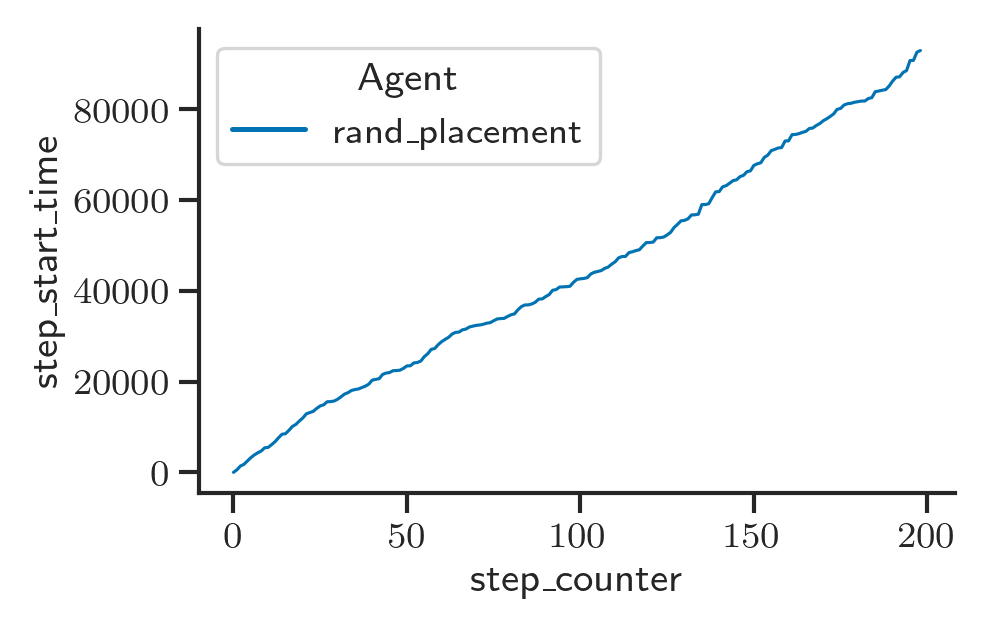

Plotting metric mean_num_active_workers


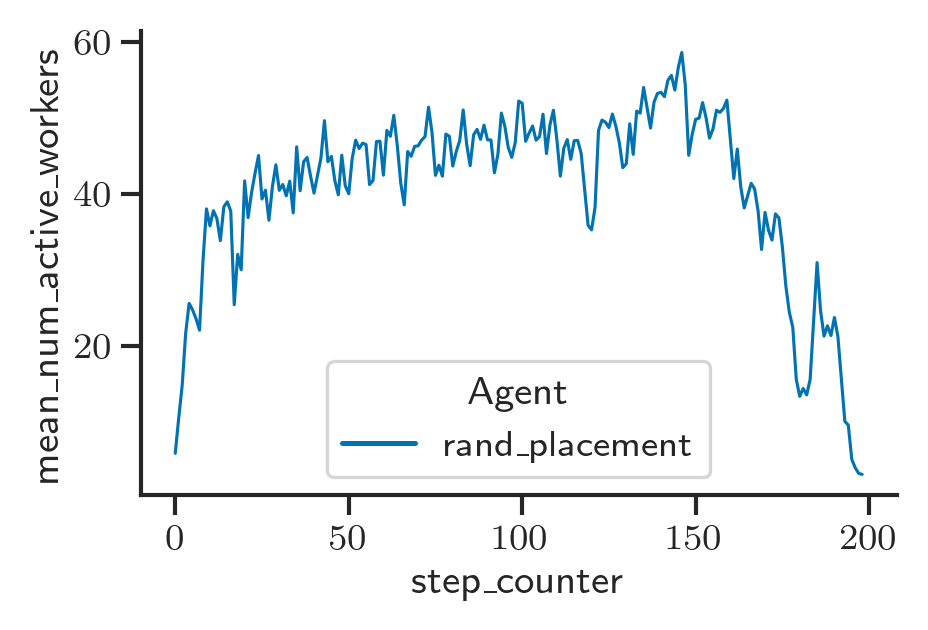

Plotting metric num_jobs_completed


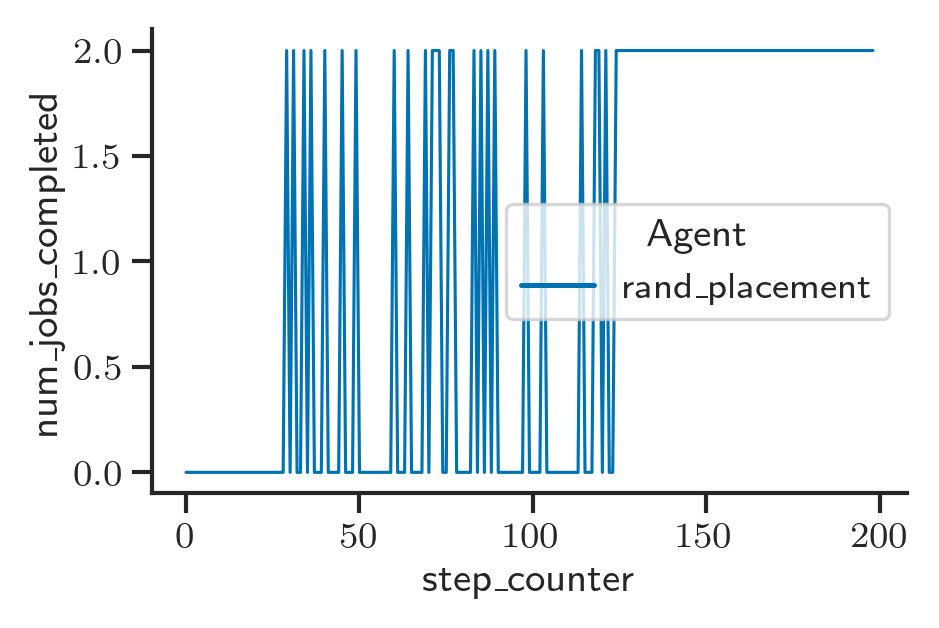

Plotting metric num_jobs_running


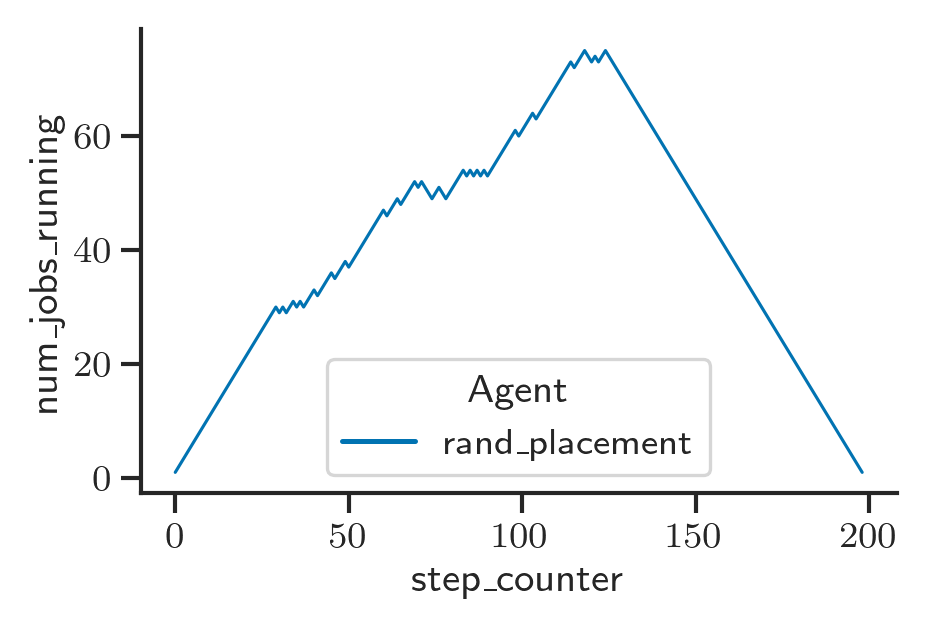

Plotting metric num_jobs_arrived


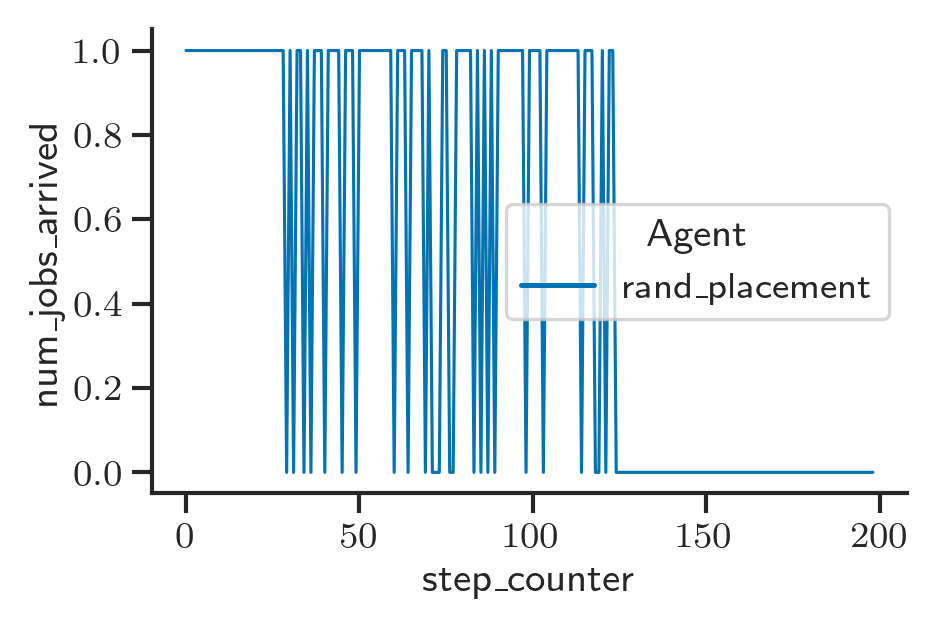

Plotting metric num_jobs_blocked


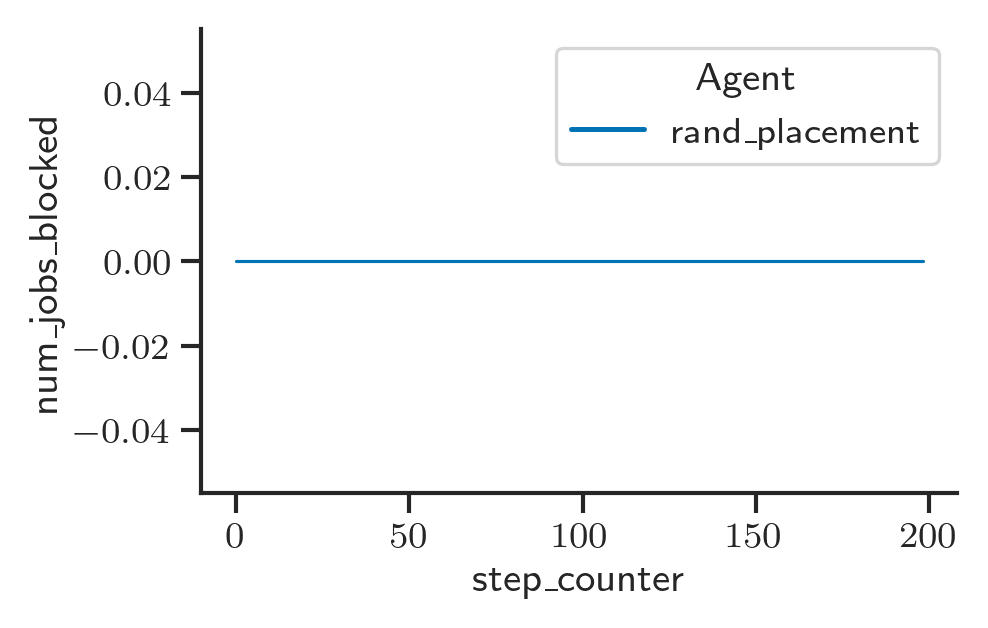

Plotting metric step_end_time


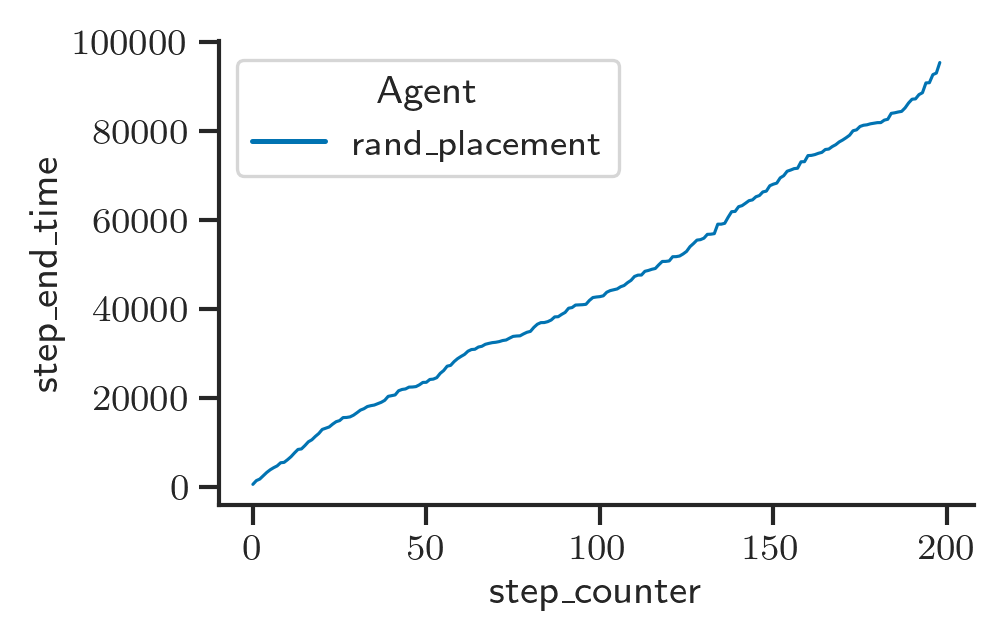

Plotting metric job_queue_length


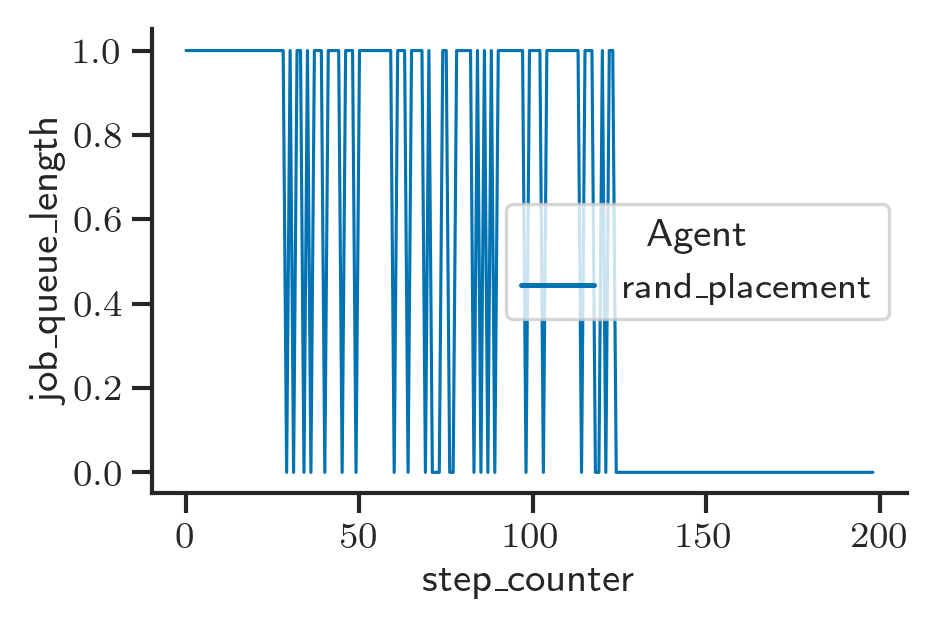

Plotting metric step_time


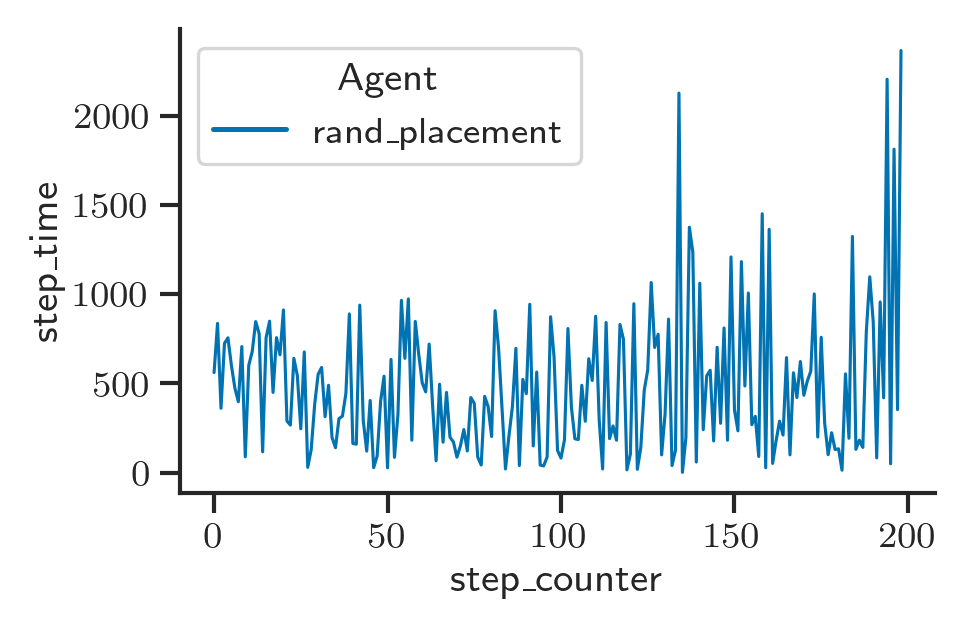

In [49]:
%autoreload
from ddls.plotting.plotting import plot_line

import pandas as pd
from collections import defaultdict


# plot config
x = 'step_counter'
scaling_factor = 1
metrics_to_skip = {'step_counter'}

# make plots
metrics = steps_logs_dict[agent].keys()
metrics_to_plot = [metric for metric in metrics if metric not in metrics_to_skip]
print(f'Metrics to plot: {metrics_to_plot}\nMetrics to skip: {metrics_to_skip}\n')
for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    plot_dict = {}
    for _agent in steps_logs_dict.keys():
        plot_dict['Agent'] = [_agent for _ in range(len(steps_logs_dict[_agent][metric]))]
        plot_dict[x] = steps_logs_dict[_agent][x]
        plot_dict[metric] = steps_logs_dict[agent][metric]
    fig = plot_line(pd.DataFrame(plot_dict), 
                    x=x, 
                    y=metric, 
                    hue='Agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    scaling_factor=scaling_factor,
                    show_fig=True)

## Sim-level metrics

E.g. Mean job completion time?

In [50]:
# import copy
# import numpy as np

# def augment_sim_logs_dict(sim_logs_dict):
#     '''Calculates additional metrics for steps logs dict.'''
#     _sim_logs_dict = copy.deepcopy(sim_logs_dict)
#     for agent in sim_logs_dict.keys():
#         for metric in ['job_completion_time']:
#             _sim_logs_dict[agent][f'mean_{metric}'] = np.mean(sim_logs_dict[agent][metric])
#             _sim_logs_dict[agent][f'p99_{metric}'] = np.percentile(sim_logs_dict[agent][metric], 99)
#             _sim_logs_dict[agent][f'median_{metric}'] = np.median(sim_logs_dict[agent][metric])
#             _sim_logs_dict[agent][f'std_{metric}'] = np.std(sim_logs_dict[agent][metric])
#     return _sim_logs_dict
# sim_logs_dict = augment_sim_logs_dict(sim_logs_dict)

Metrics to plot: ['job_completion_time', 'jobs_completed_num_nodes', 'jobs_completed_num_edges', 'jobs_completed_total_operation_memory_cost', 'jobs_completed_total_dependency_size']
Metrics to skip: {}

Plotting metric job_completion_time


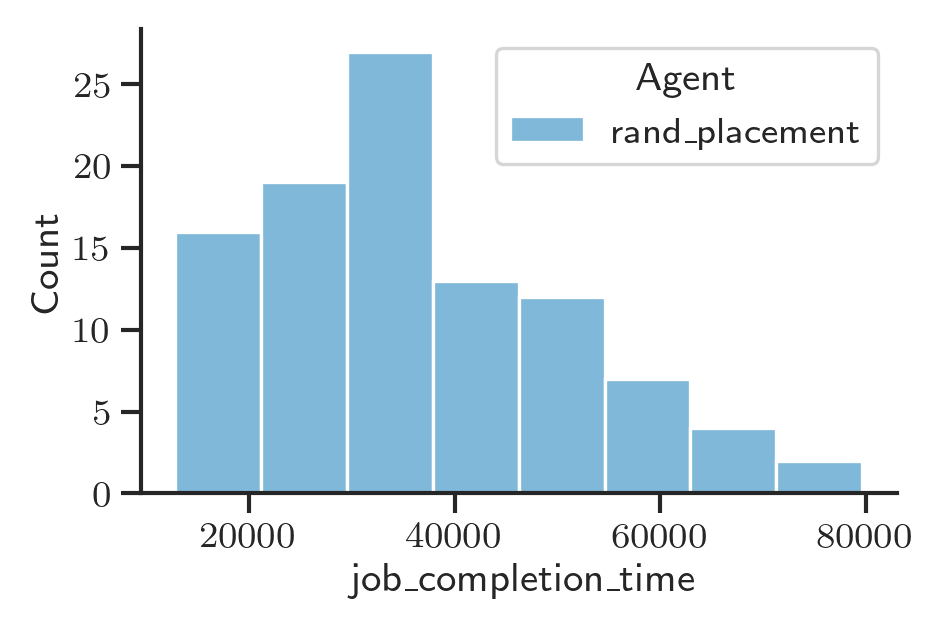

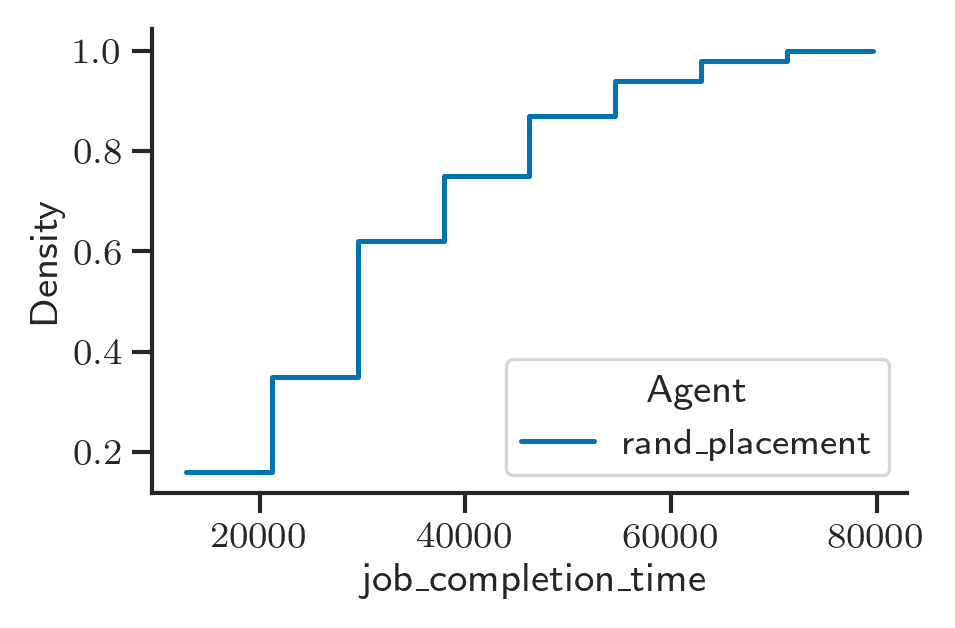

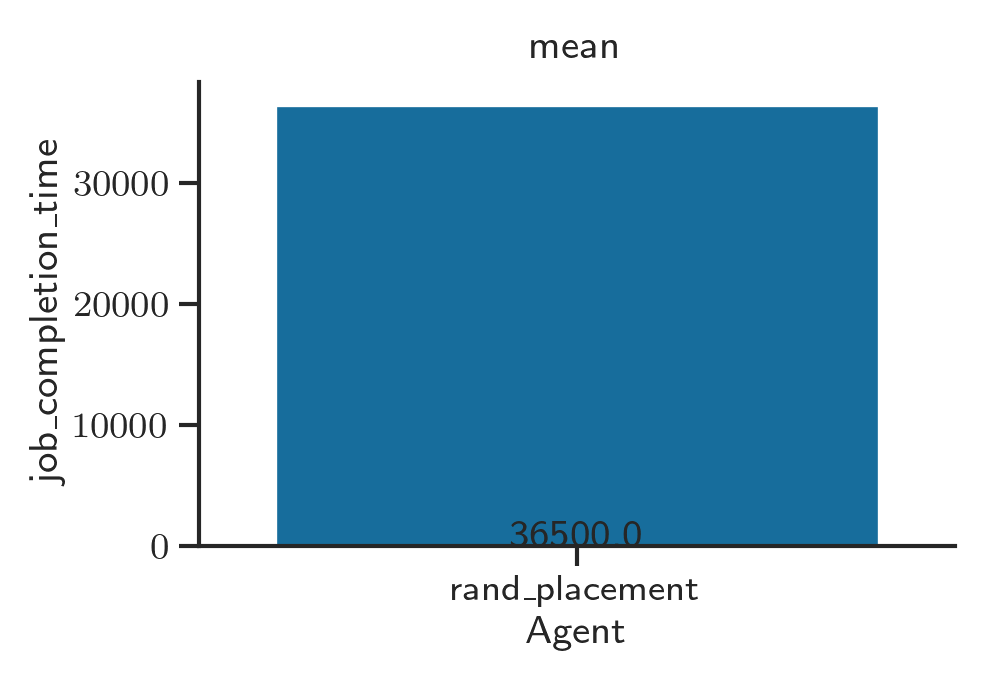

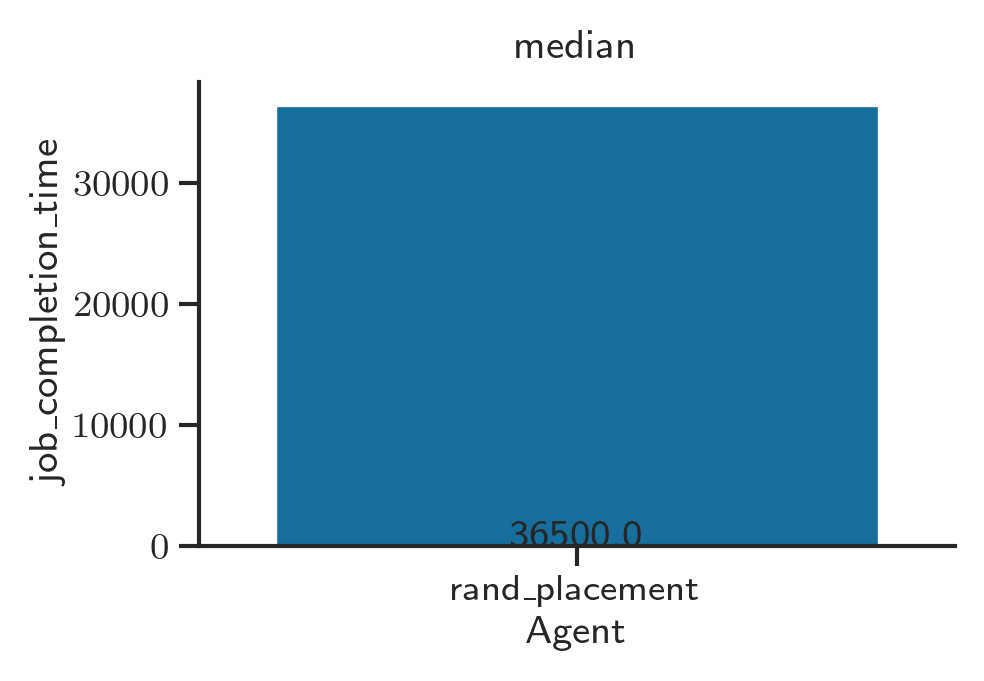

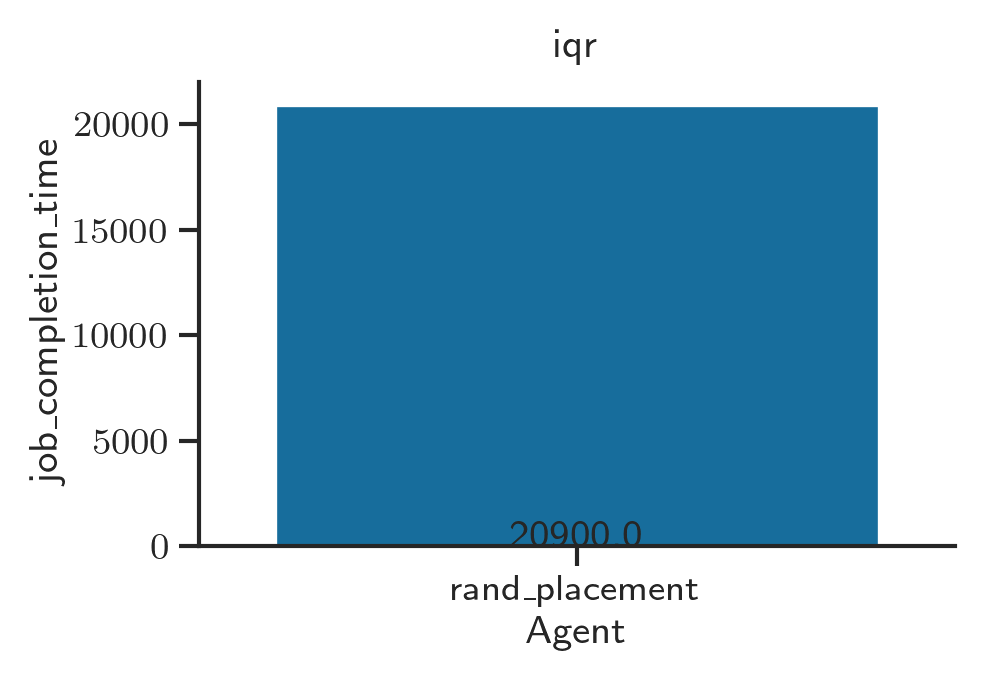

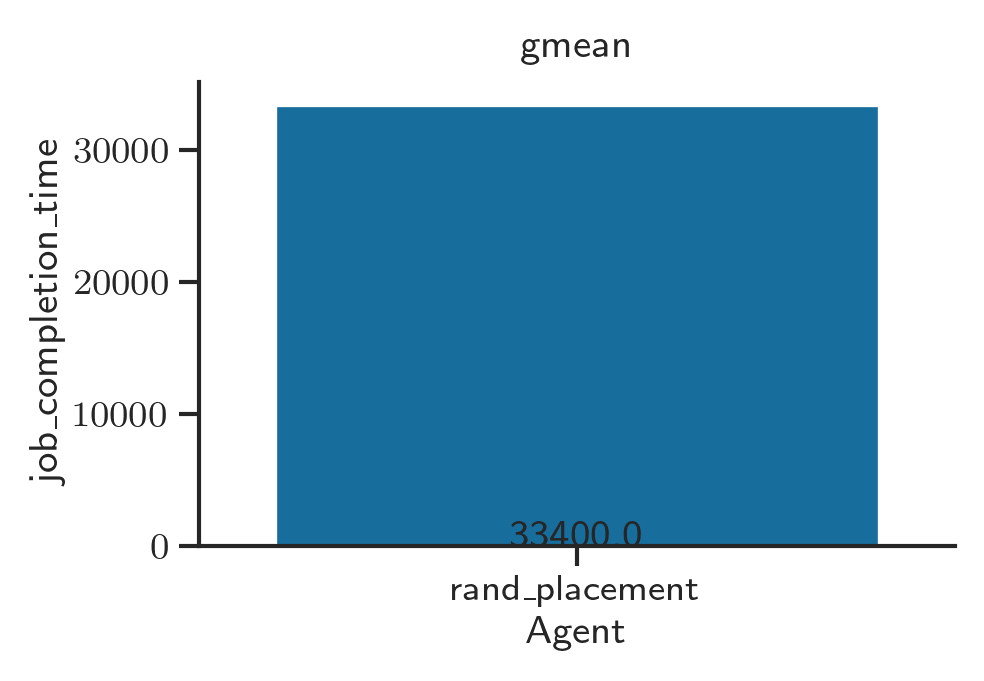

Plotting metric jobs_completed_num_nodes


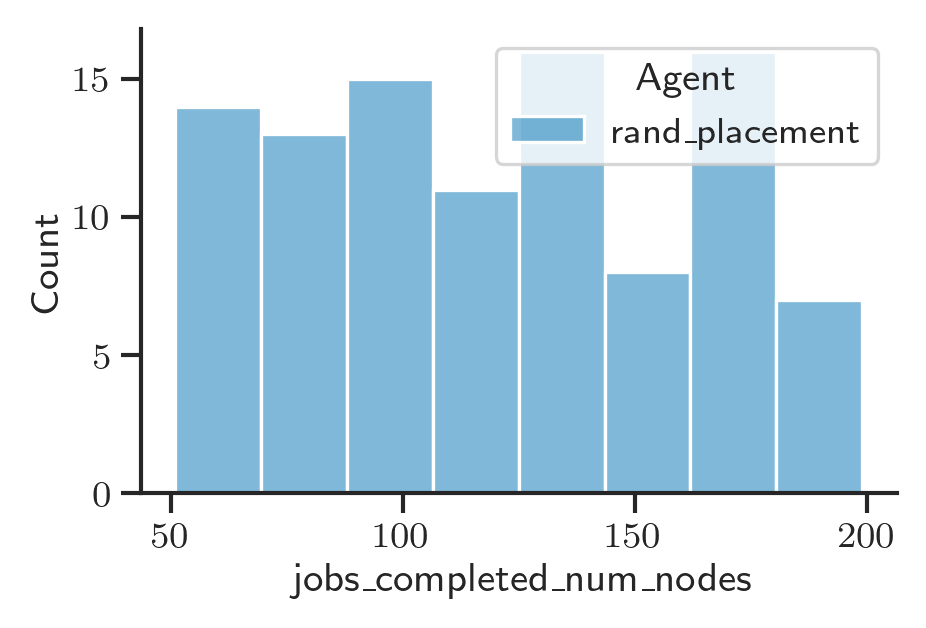

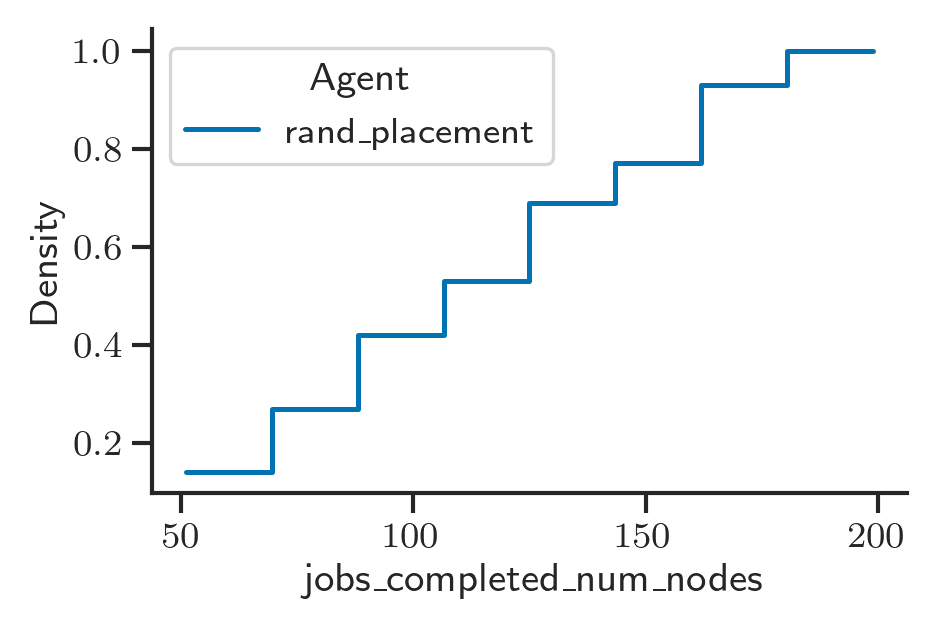

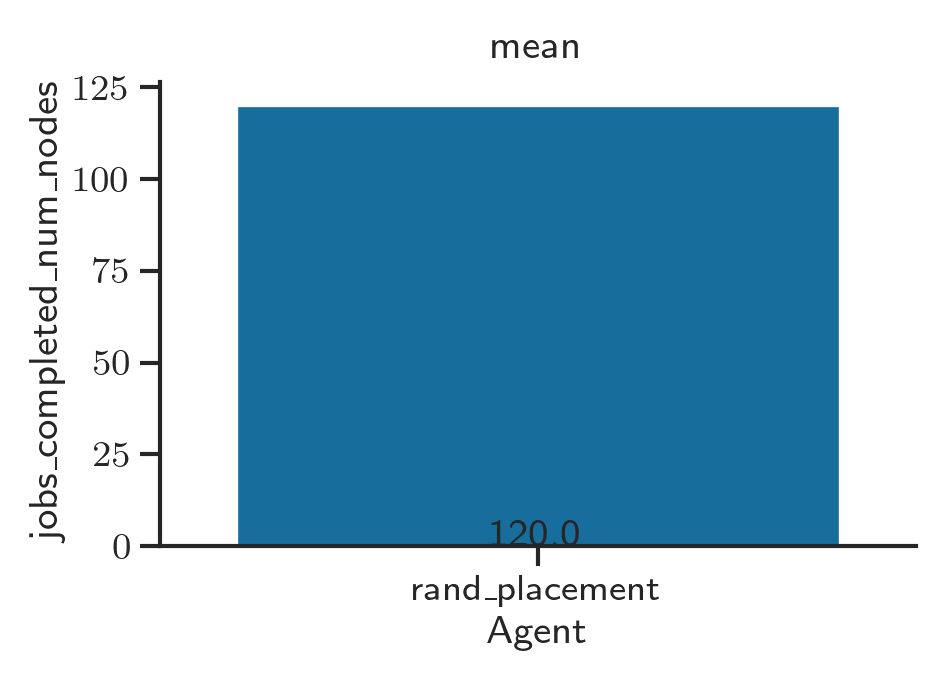

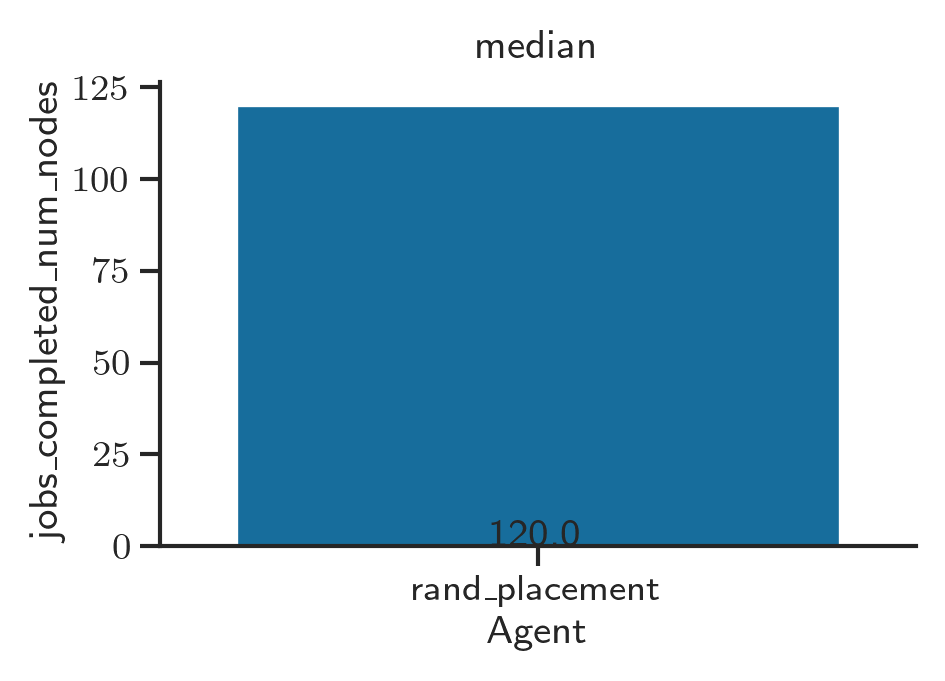

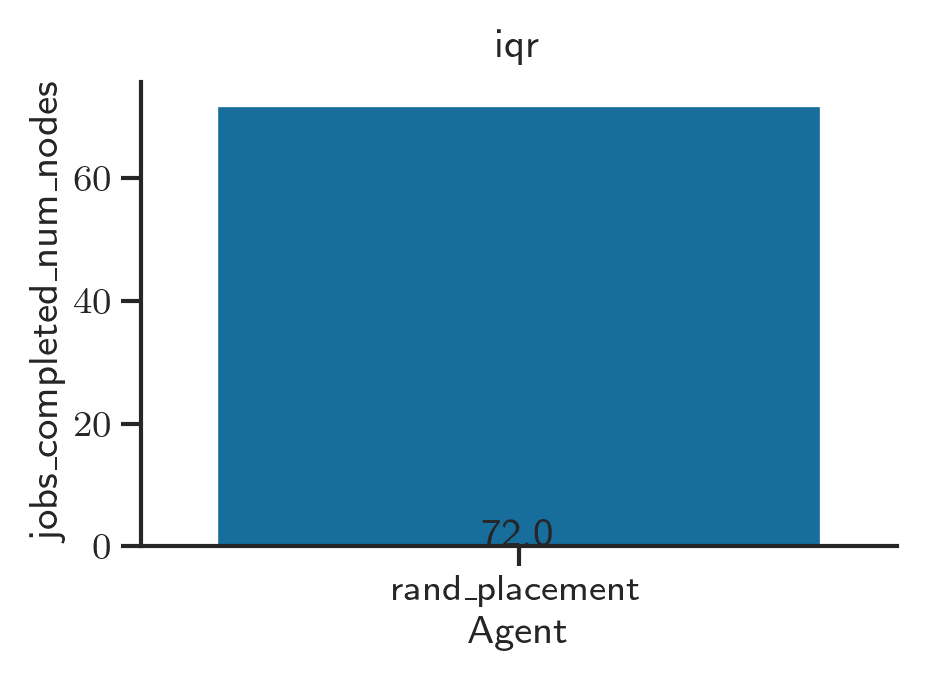

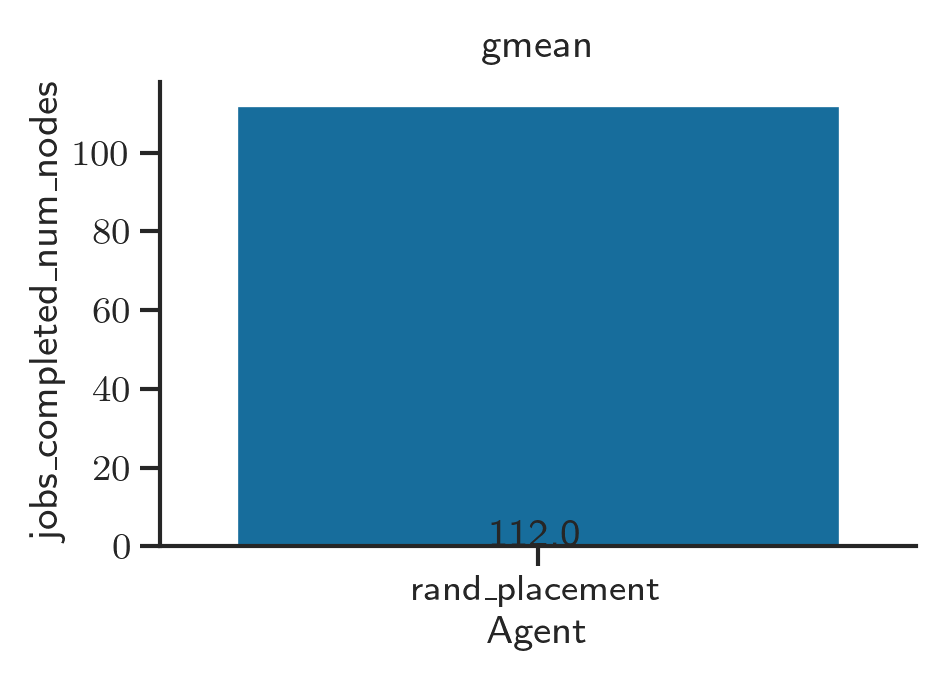

Plotting metric jobs_completed_num_edges


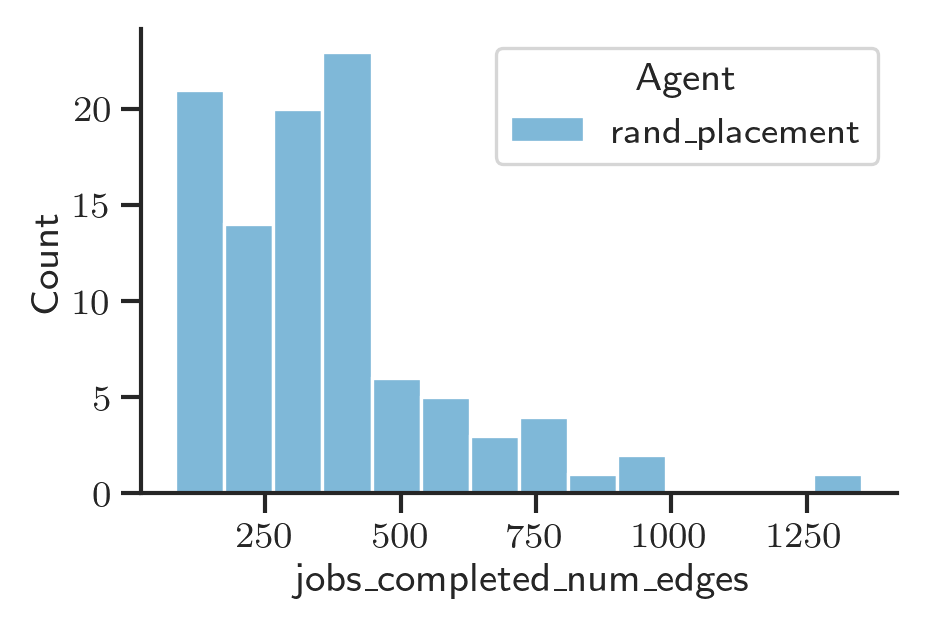

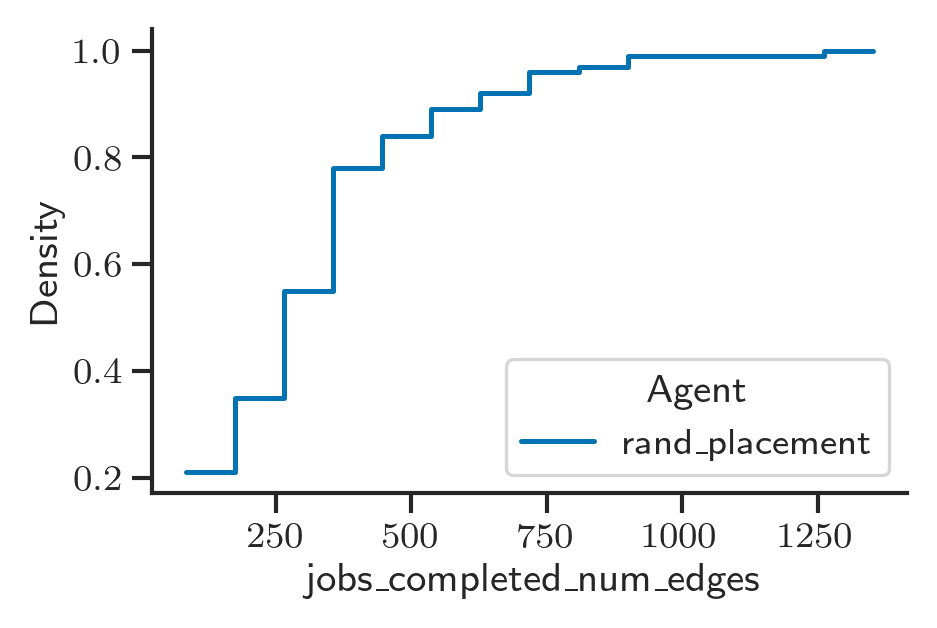

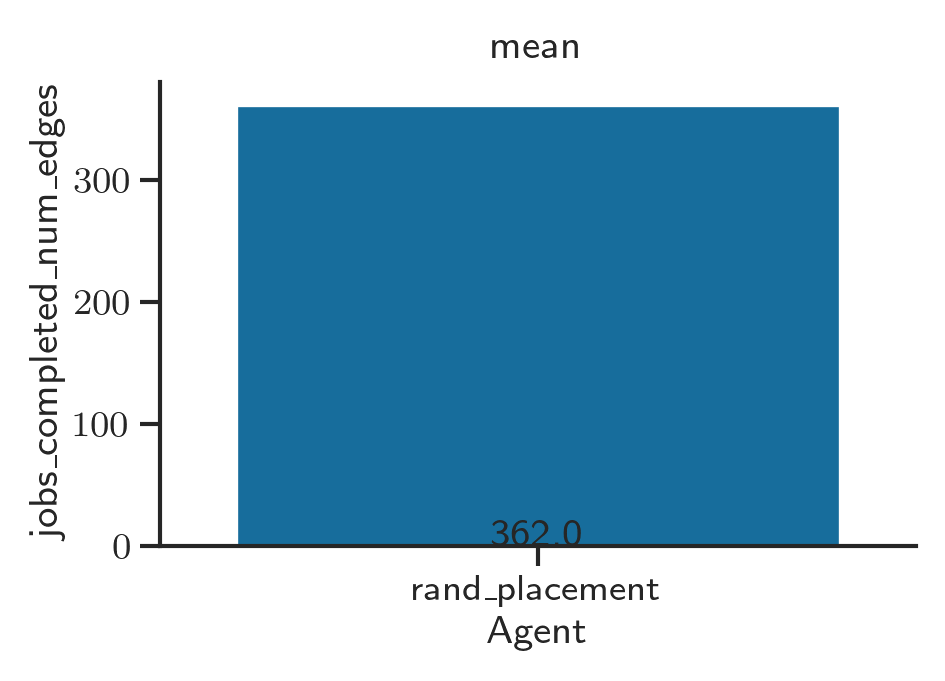

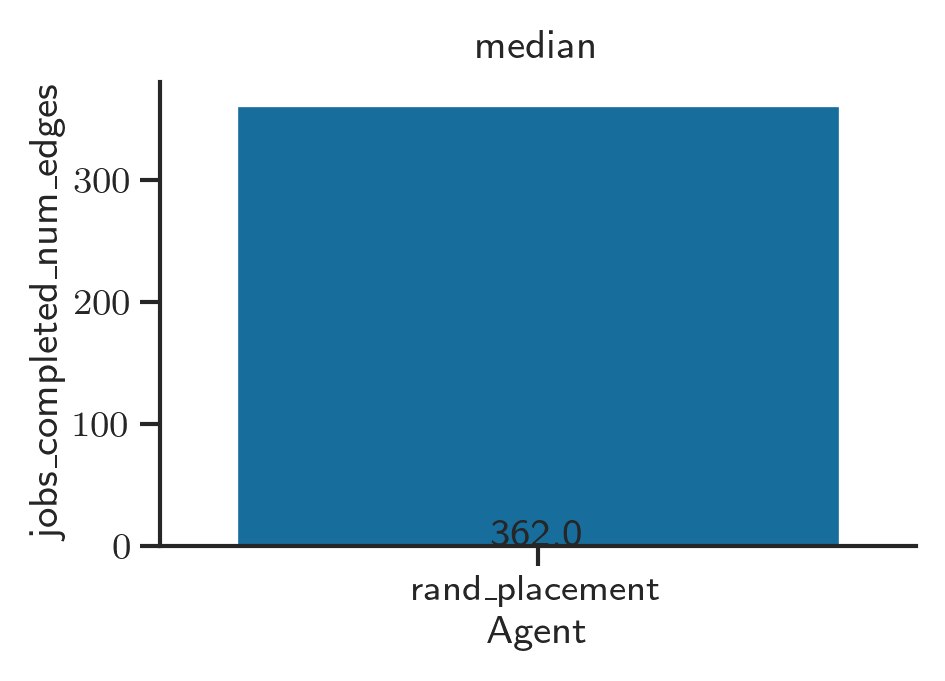

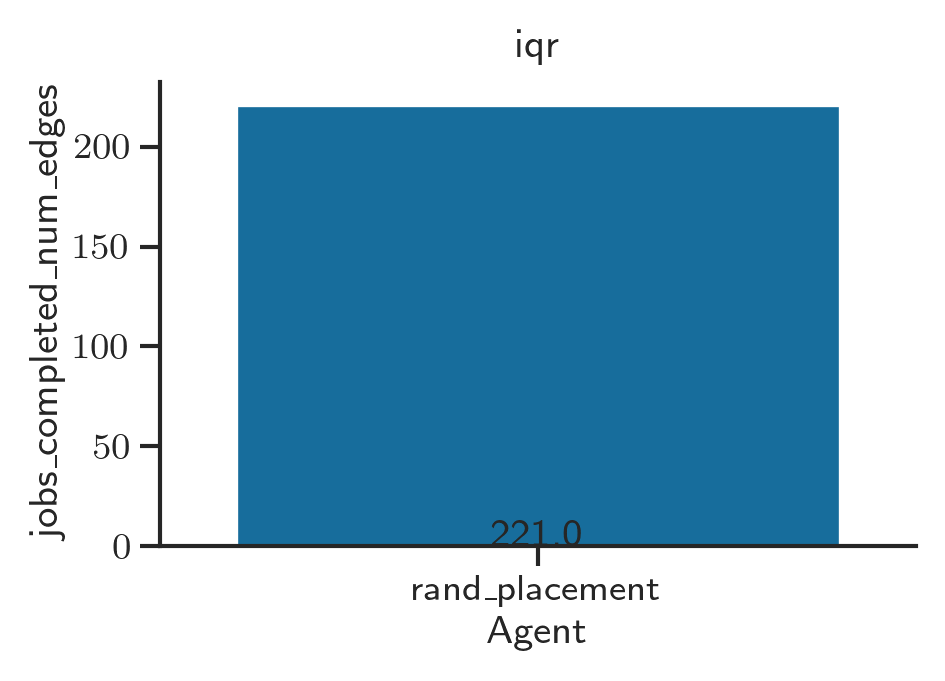

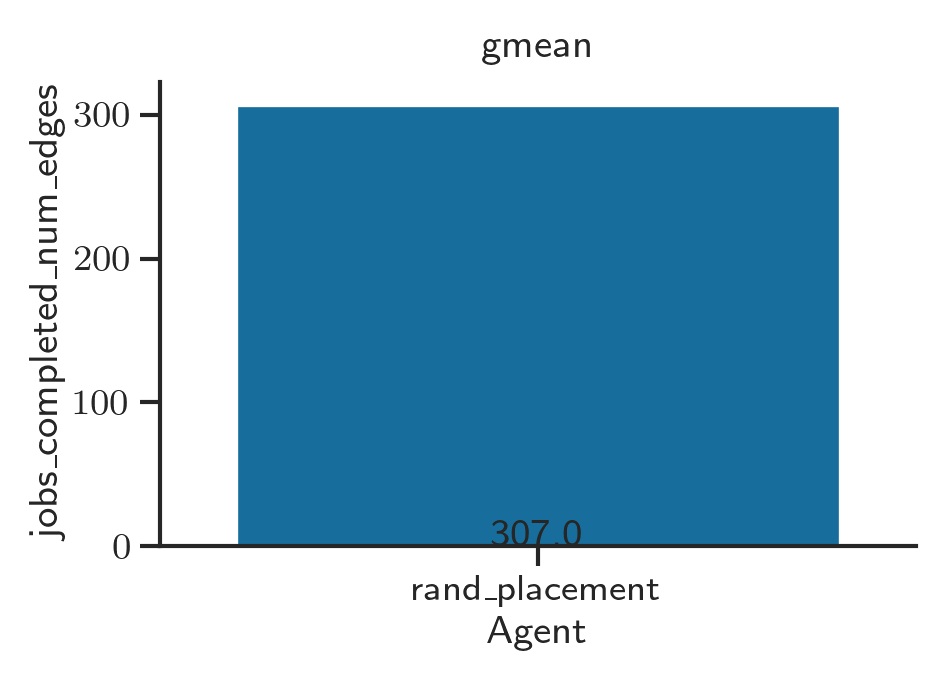

Plotting metric jobs_completed_total_operation_memory_cost


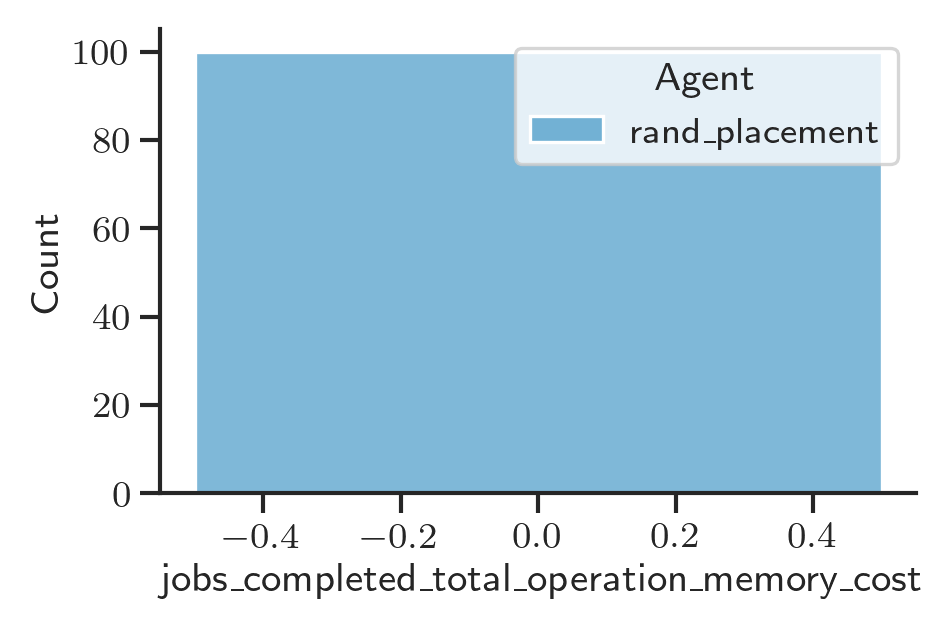

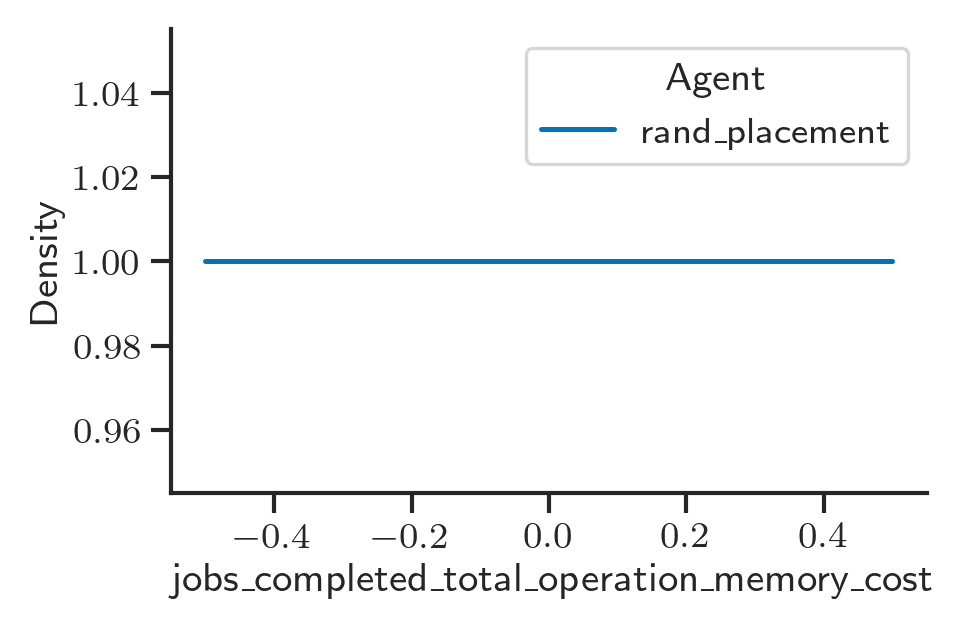

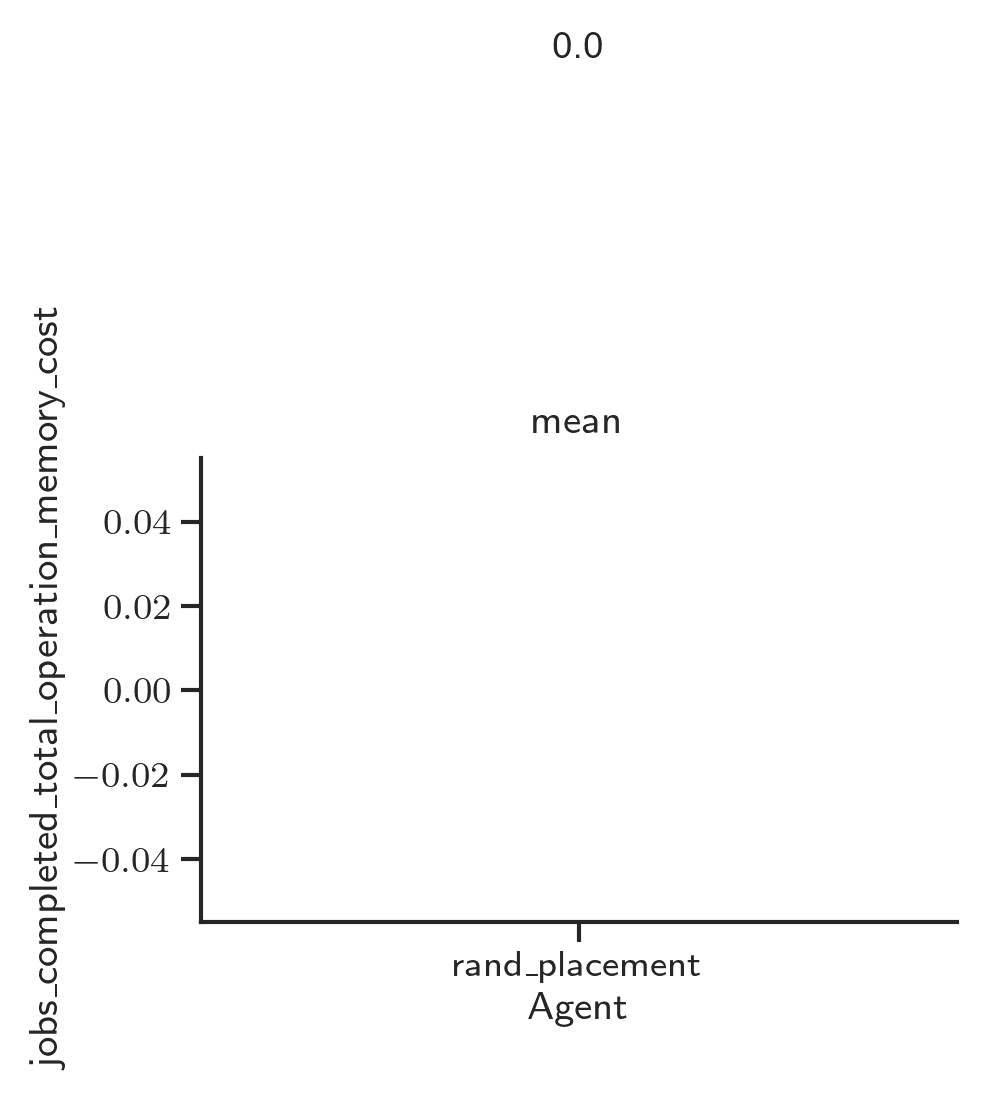

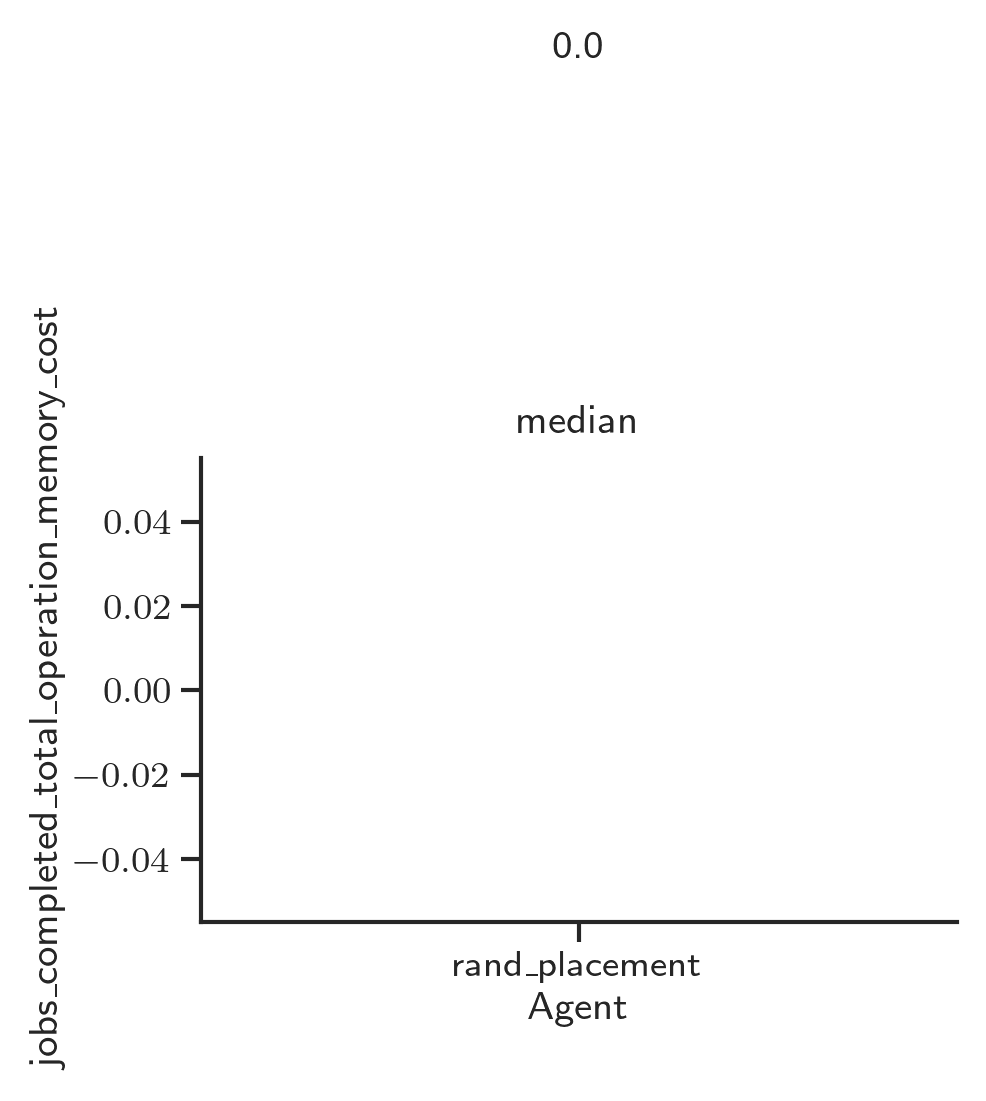

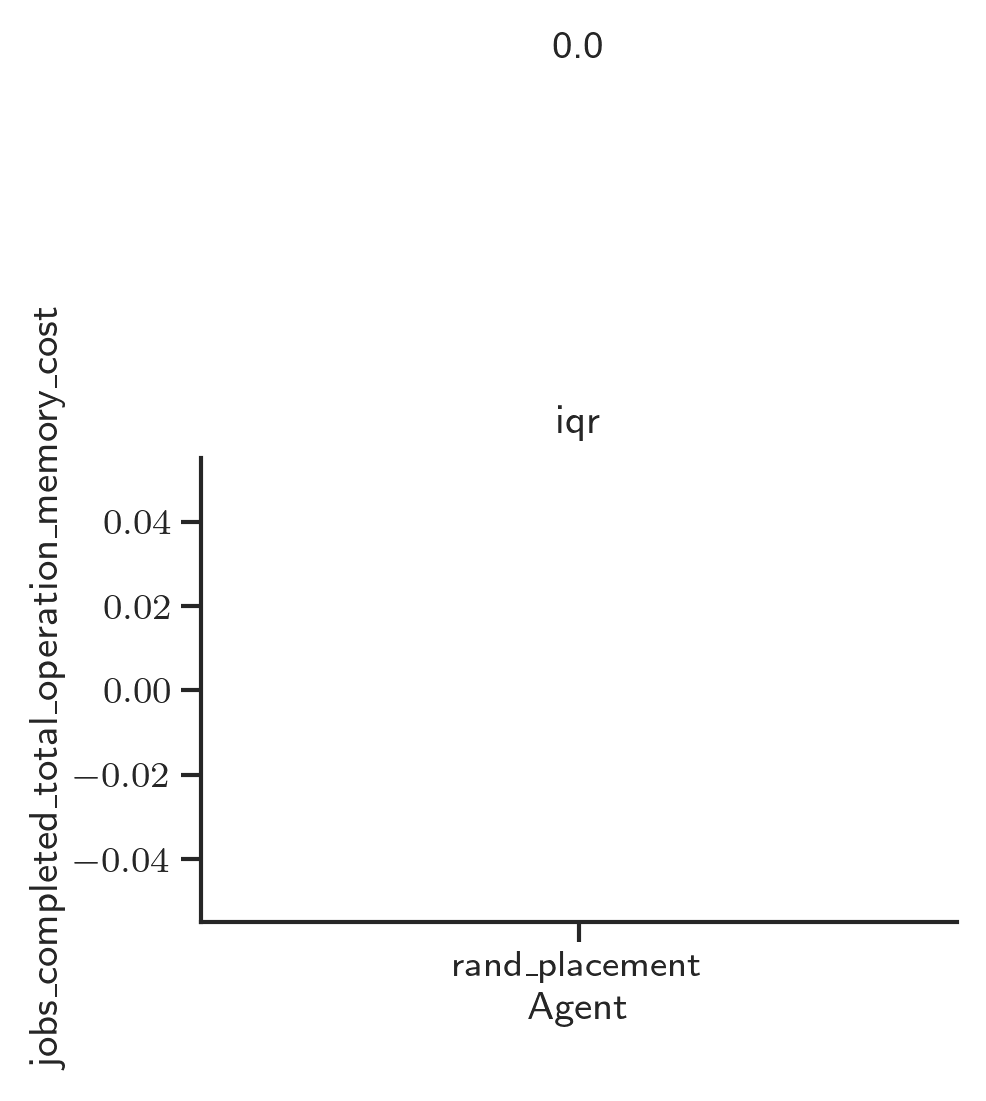

/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/scipy/stats/stats.py:275: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


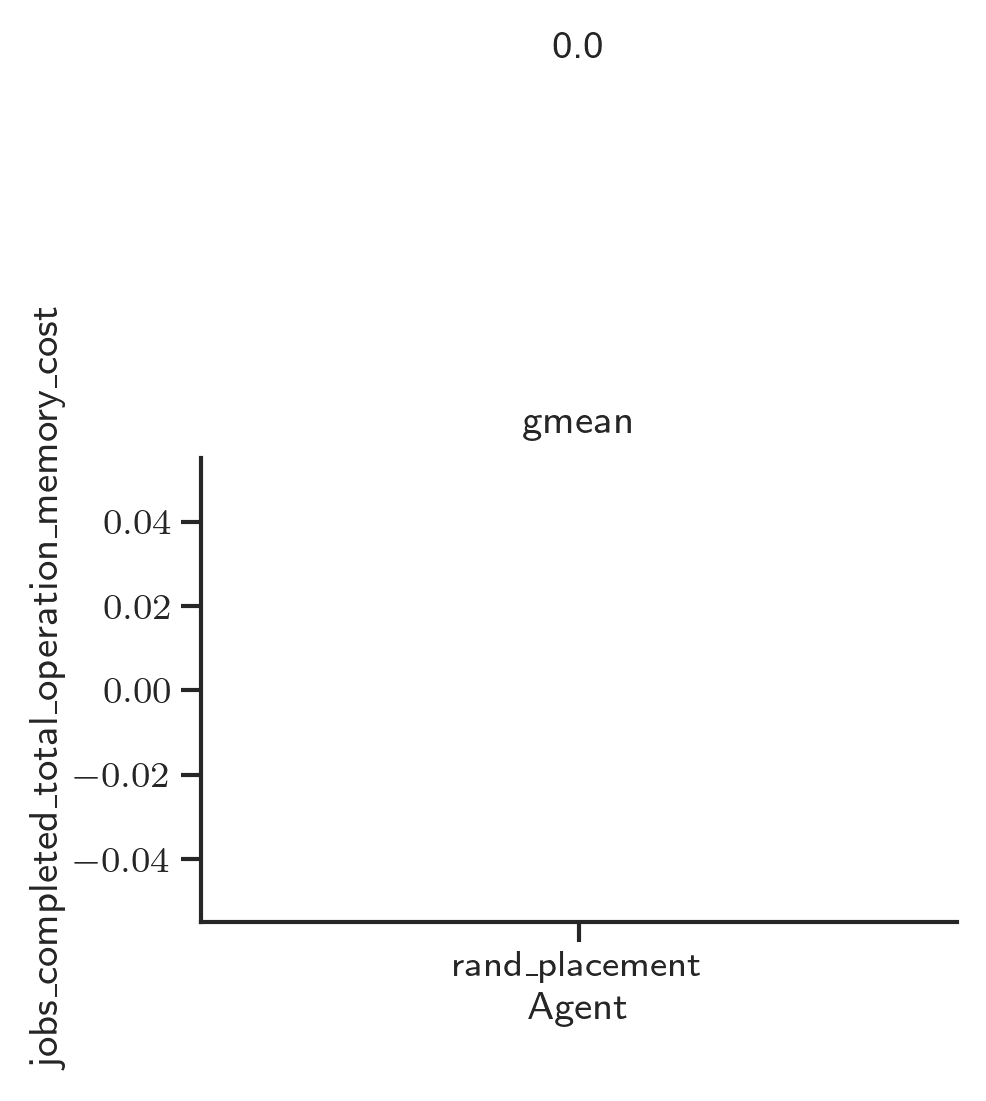

Plotting metric jobs_completed_total_dependency_size


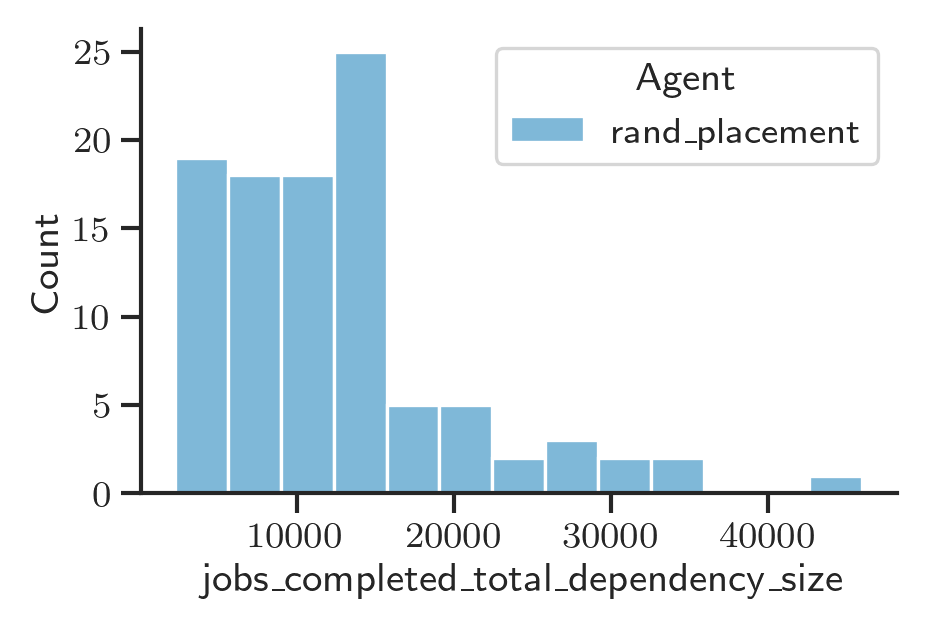

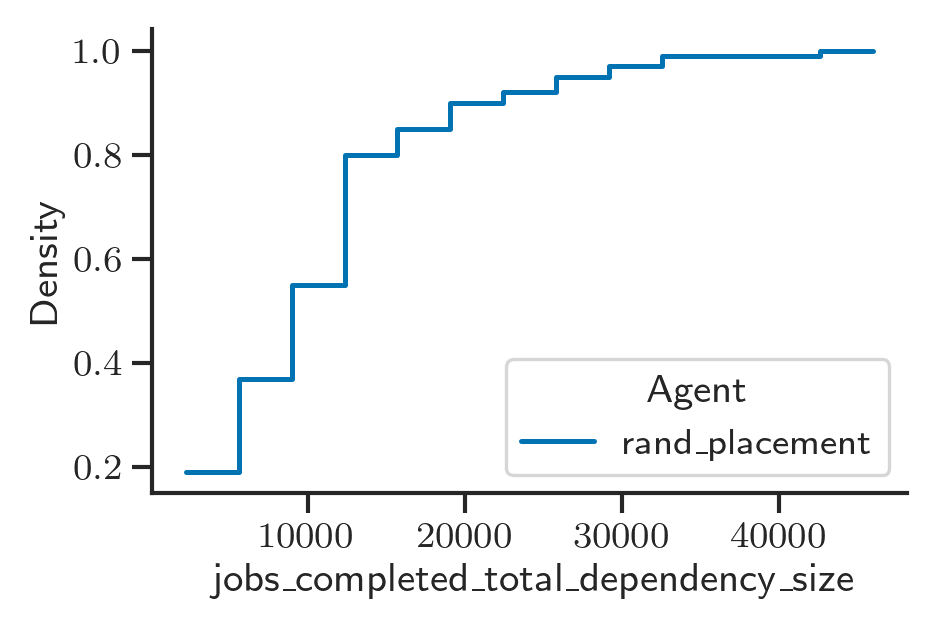

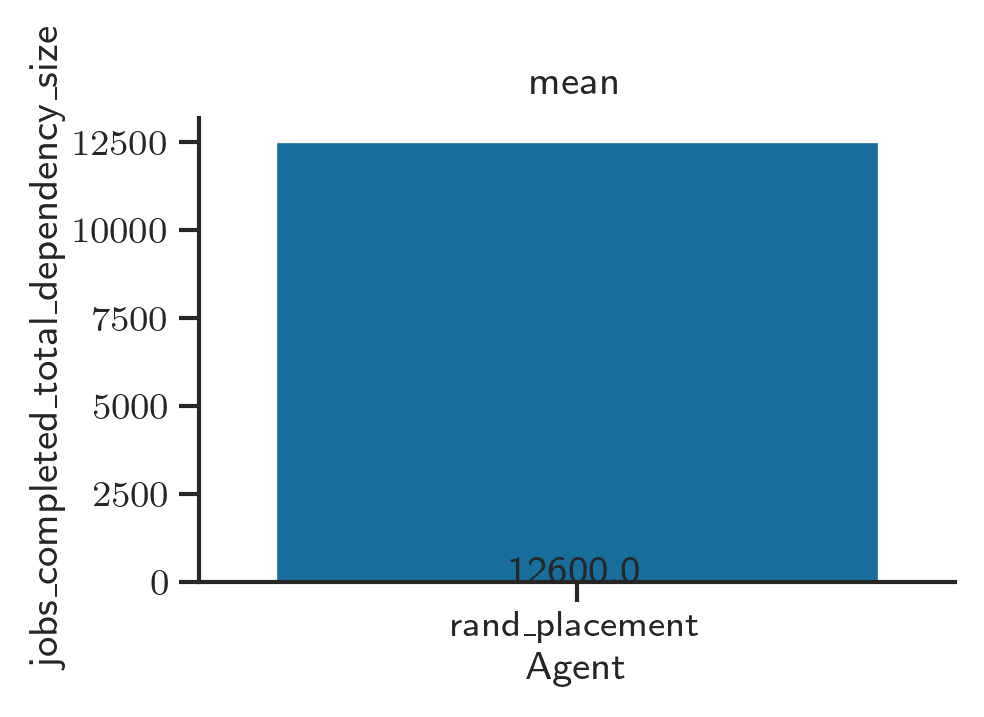

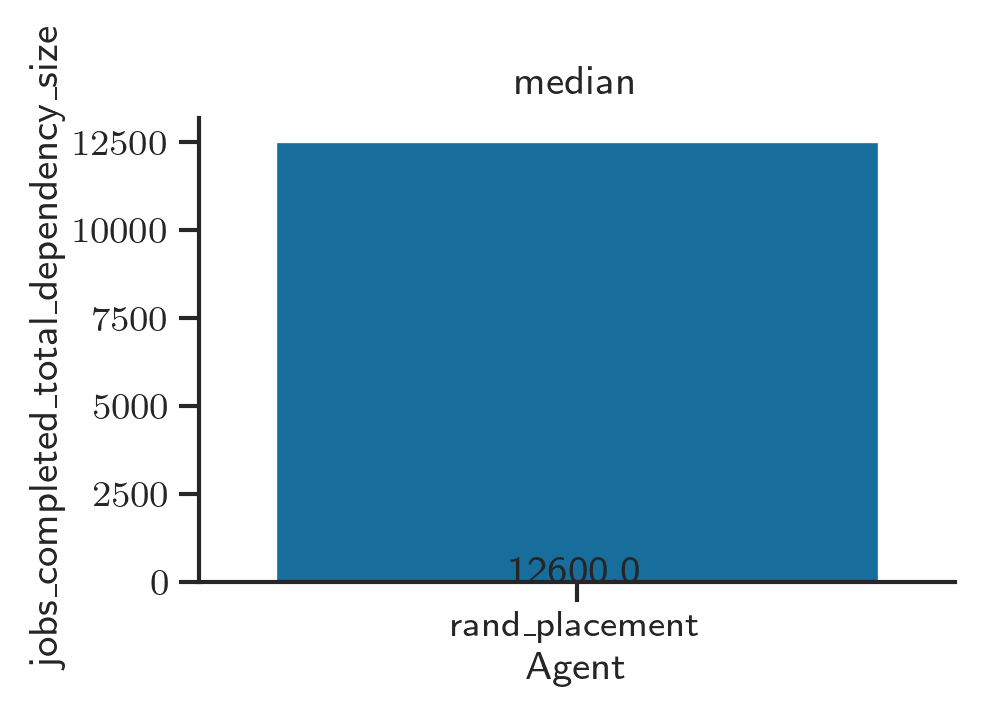

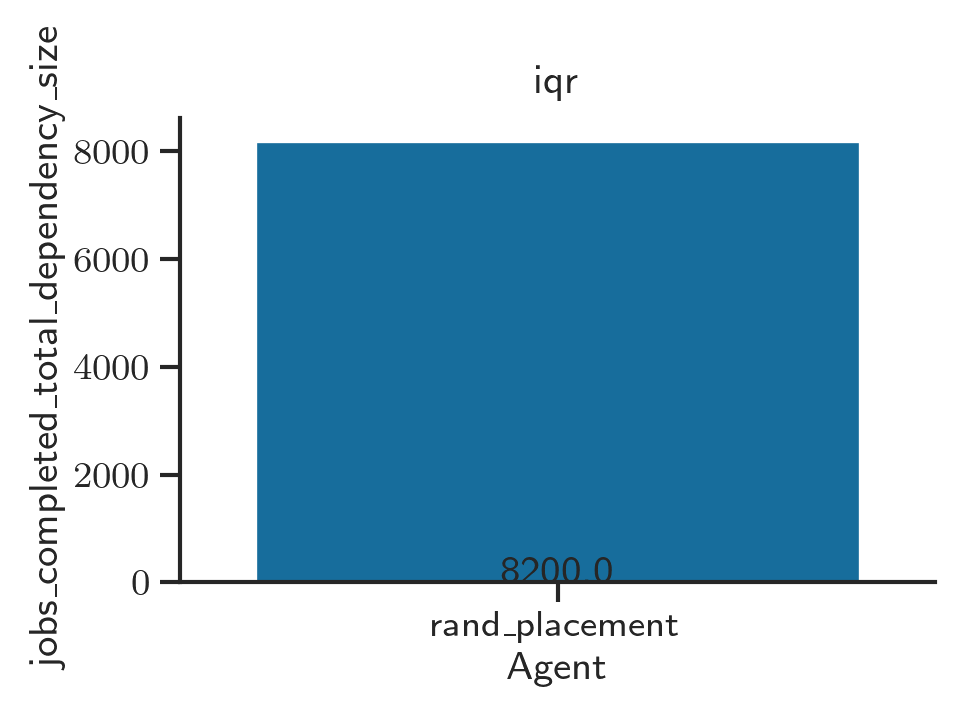

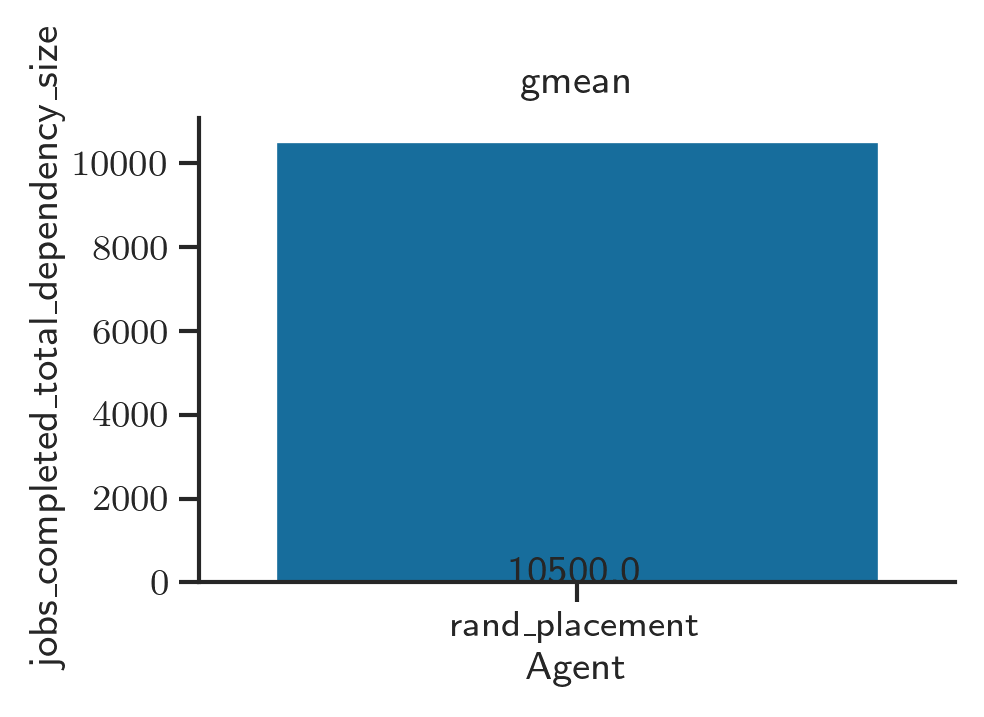

In [51]:
%autoreload
from ddls.plotting.plotting import plot_bar, plot_hist

import pandas as pd
from collections import defaultdict
import numpy as np
import scipy.stats as st


# plot config
scaling_factor = 1
metrics_to_skip = {}
estimators = {'mean': np.mean,
              'median': np.mean,
              'iqr': st.iqr,
              'gmean': st.gmean}


# make plots
metrics = sim_logs_dict[agent].keys()
metrics_to_plot = [metric for metric in metrics if metric not in metrics_to_skip]
print(f'Metrics to plot: {metrics_to_plot}\nMetrics to skip: {metrics_to_skip}\n')
for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    plot_dict = {}
    for _agent in sim_logs_dict.keys():
        plot_dict['Agent'] = [_agent for _ in range(len(sim_logs_dict[_agent][metric]))]
        plot_dict[metric] = sim_logs_dict[agent][metric]
        
    df = pd.DataFrame(plot_dict)
        
    # hist
    fig = plot_hist(df,
                    x=metric,
                    hue='Agent',
                    xlabel=metric,
                    element='bars',
                    fill=True,
                    cumulative=False,
                    stat='count',
                    multiple='layer',
                    scaling_factor=scaling_factor,
                    show_fig=True)
    
    # cdf
    fig = plot_hist(df,
                    x=metric,
                    hue='Agent',
                    xlabel=metric,
                    element='step',
                    fill=False,
                    cumulative=True,
                    stat='density',
                    common_norm=False,
                    scaling_factor=scaling_factor,
                    show_fig=True)
        
    # bar chart
    for estimator_name, estimator in estimators.items():
        fig = plot_bar(df, 
                        x='Agent', 
                        y=metric, 
                        xlabel='Agent', 
                        ylabel=metric, 
                        estimator=estimator,
                        title=estimator_name,
                        scaling_factor=scaling_factor,
                        show_fig=True)